<a href="https://colab.research.google.com/github/ddlandim/monografy-ann-demand-prediction/blob/master/case2__Experimentos_2709.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUÇÃO À ESTE DOCUMENTO:

Este é um notebook experimental para o meu trabalho de graduação em ciência da computação na Universidade Federal de São Paulo. Com data prevista de conclusão em 19 de 10 outubro de 2020

Este caso de experimentos, denominado "case2" realiza experimentos com dados de consumo e venda de refeições do restaurante universitário da Unifesp, utilizando:
- o ano de 2017 como conjunto de treino, 
- 2018 como conjunto de validação 
- e 2019 como conjunto de teste.

Os modelos de aprendizado de máquina implementados são modelos de redes neurais perceptron e redes GRU (gated recurrent unit).

As classes de modelos são:
- Endógenos, onde os modelos utilizam apenas dados referentes à venda e consumo de refeiçoes distribuídos em formato de série temporal, com um intervalo temporal de 5 dias para a previsão do próximo dia.
- Mistos endógenos e exógenos, onde os modelos utilizam além dos dados temporais e endógenos, dados discretos climáticos, dados discretos de calendário (percentual escalar da data em referencia ao avanço do mes ou semestre, distancia em dias até o registro anterior e posterior de consumo) e dados categóricos-binários representando o dia da semana da data dos registros.

Para executar este notebook, você pode conectar sua conta do google-drive nas primeiras 2 células de código para que os modelos treinados, e resultados experimentais, sejam exportados para a pasta default de notebooks "google-colab" do Google Drive. Para salvar os dados na memória da seção e não no google drive, basta apenas não executar as 2 primeiras células.

PARA APENAS VERIFICAR OS MODELOS JÁ TREINADOS E SUAS MÉTRICAS E RESULTADOS, VÁ DIRETO PARA O LINK "DRIVER-CODE" ONDE OS MODELOS COM OS MELHORES RESULTADOS SÃO IMPORTADOS E EXECUTADOS: https://colab.research.google.com/drive/1bBMTP9YQcy6sRNHZTr3NRSt1YCxJyu5t?usp=sharing

PARA VERIFICAR O CASO ANTERIOR DE EXPERIMENTOS VÁ PARA O LINK: 
https://colab.research.google.com/drive/1spSZDJk1EwK9UK-jfYbWinKEq0EEYIuM?usp=sharing

# SETUP DO DIRETORIO DO GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


# **IMPORT E LOAD DE DADOS**

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('ggplot')
# PROCESSAMENTO
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# MODELOS
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

import seaborn as sns
import scipy

# PREPROCESSAMENTO E METRICAS
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *

# EXPORTAÇÃO
# Lib para exportar scalers
# https://scikit-learn.org/stable/modules/model_persistence.html
from joblib import dump, load

# Lib para exportar numpy ou arrays
# https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html
import h5py

In [2]:
infile = "https://raw.githubusercontent.com/ddlandim/monografy-ann-demand-prediction/master/Data/dataset.csv"

dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

df = pd.read_csv(infile, parse_dates=['DATA'], date_parser=dateparse,index_col='DATA')

df

SEMESTRE_1  SEMESTRE_2  ...  ENTR_JANTAR_4  ENTR_JANTAR_5
DATA                                ...                              
2017-04-12           1           0  ...              0              0
2017-04-13           1           0  ...              0              0
2017-04-17           1           0  ...              0              0
2017-04-18           1           0  ...              0              0
2017-04-19           1           0  ...              0              0
...                ...         ...  ...            ...            ...
2019-12-10           0           1  ...            111            163
2019-12-11           0           1  ...            132            111
2019-12-12           0           1  ...             39            132
2019-12-13           0           1  ...             69             39
2019-12-16           0           1  ...             19             69

[514 rows x 33 columns]

In [ ]:
# Testando lag temporal
df['ENTR_ALMOCO_1'][50] == df['ENTR_ALMOCO_2'][51]

True

#### **FUNÇÕES AUXILIARES**

In [ ]:
# plota serie
def plot_serie(serie, size=(12,4), title='Plot'):
    plt.figure(figsize=size)
    plt.title(title)
    plt.plot(serie)
    plt.show()

In [ ]:
# pega coluna dataframe['coluna_y'] e usa como y
# todas as outras colunas usa como x 
def to_supervised_numpy(dataframe, coluna_y):
    X = dataframe.loc[:, dataframe.columns != coluna_y].values # instantes de tempo passado (lags)
    Y = dataframe[coluna_y].values # valor atual para prever
    return np.array(X), np.array(Y)

In [ ]:
def plot_history(history, start_epoch=0):
    start_epoch = 10
    plt.figure(figsize=(10,4))
    plt.title('História Treino')
    plt.plot(history.history['loss'][start_epoch:], label='Train Loss')
    plt.plot(history.history['val_loss'][start_epoch:], label='Validation Loss')
    plt.legend()

In [ ]:
df_models_metrics = pd.DataFrame(columns=['MODELO','TOTAL_CONSUMIDAS','TOTAL_PREVISTAS','ERRO_TOTAL_PREVISAO','ERRO_TOTAL_PERC_PREVISAO', 'CORRELACAO', 'pi', 'RMSE', 'TOTAL_FALTA', 'TOTAL_DESCARTE', 'ERRO_ABS_MEDIANO' , 'ERRO_ABSOLUTO_PERCENTUAL_MEDIO'])
df_models_metrics = df_models_metrics.set_index('MODELO')
df_models_metrics

Empty DataFrame
Columns: [TOTAL_CONSUMIDAS, TOTAL_PREVISTAS, ERRO_TOTAL_PREVISAO, ERRO_TOTAL_PERC_PREVISAO, CORRELACAO, pi, RMSE, TOTAL_FALTA, TOTAL_DESCARTE, ERRO_ABS_MEDIANO, ERRO_ABSOLUTO_PERCENTUAL_MEDIO]
Index: []

In [ ]:
def pe (row,true,predicted): # array of % error
    true = row[true]
    predicted = int(row[predicted])
    error = predicted - true
    if true == 0:
        pe = 0
    else:
        pe = abs(error/true)
    return pe,error

def mape (_df,x,y): # mean of array of % error
    df = pd.DataFrame()
    df = _df
    arr_pe = [0,0]
    arr_pe = df.apply(lambda row: pe(row,x,y), axis=1)
    return np.mean(arr_pe[0])*100 , arr_pe[1]

def mean_absolute_percentage_error(y_true, y_pred): 
  y_true = np.maximum(y_true, 1e-7)  # Prevent division by zero
  return 100. * np.mean(np.abs((y_true - y_pred) / y_true))

def avaliacao_predicoes (_df_true,_trueStr,_predStr,_df_models_metrics):
  m_df_models_metrics = pd.DataFrame()
  m_df_models_metrics = _df_models_metrics
  df = pd.DataFrame()
  df = _df_true

  arr_true = df[_trueStr]
  sum_true = np.sum(arr_true)
  len_true = len(arr_true)

  arr_pred = df[_predStr]
  sum_pred = np.sum(arr_pred)
  len_pred = len(arr_pred)

  diff_len = len_true - len_pred
  perc_diff_len = (diff_len / len_true) * 100

  arr_e = arr_true - arr_pred

  print("TOTAL DE REFEIÇÕES CONSUMIDAS = " + str(sum_true) + " : " + str(len_true) + " linhas")
  print("TOTAL DE REFEIÇÕES PROJETADAS = " + str(sum_pred) + " : " + str(len_pred) + " linhas")
  print("ERRO DE PREVISÃO = " + str(diff_len) + " " + str(perc_diff_len) + " % do total consumido")

  m_r, m_p = scipy.stats.pearsonr(arr_true, arr_pred)
  print("CORRELAÇÃO (r): " + str(m_r) + " Pi (p) :" + str(m_p))
  sns.regplot(x=arr_true,y=arr_pred,data=df)

  rmse = mean_squared_error(arr_true, arr_pred, squared=False)
  print("RMSE = " + str(rmse))

  m_mae = np.median(np.abs(arr_e))
  m_mape = mean_absolute_percentage_error(arr_true,arr_pred)

  subpredictions = sum(i for i in arr_e if i < 0)
  superpredictions = sum(i for i in arr_e if i >= 0)

  print("TOTAL DE REFEIÇÕES SUB PROJETADAS = " + str(subpredictions))
  print("TOTAL DE REFEIÇÕES SUPER PROJETADAS = " + str(superpredictions))
  print("ERRO ABSOLUTO MEDIANO = " + str(m_mae))
  print("ERRO ABSOLUTO PERCENTUAL MEDIO = " + str(m_mape)+"%")
  plt.figure(figsize=(30,5))
  df[_trueStr].plot( linewidth=1.5, color='red', label = (_trueStr + 'REAL'))
  df[_predStr].plot( linewidth=2.5, color='blue', label = (_trueStr + 'PREVISTO'))
  plt.legend()
  plt.xlabel("Index", labelpad=15)
  plt.show()
  #['MODELO','TOTAL_CONSUMIDAS','TOTAL_PROJETADAS','ERRO_PROJECAO', 'CORRELACAO', 'pi', 'RMSE', 'TOTAL SUBPROJETADO', 'TOTAL SUPER PROJETADO ', 'ERRO ABS MEDIANO' , 'ERRO ABSOLUTO PERCENTUAL MEDIO']
  new_row = pd.Series(data={ 'TOTAL_CONSUMIDAS':sum_true, 
          'TOTAL_PREVISTAS':sum_pred, 
          'ERRO_TOTAL_PREVISAO':diff_len,
          'ERRO_TOTAL_PERC_PREVISAO':perc_diff_len,
          'CORRELACAO':m_r, 
          'pi':m_p, 
          'RMSE':rmse, 
          'TOTAL_FALTA':subpredictions, 
          'TOTAL_DESCARTE':superpredictions, 
          'ERRO_ABS_MEDIANO':m_mae, 
          'ERRO_ABSOLUTO_PERCENTUAL_MEDIO':m_mape}, 
          name = _predStr)
  m_df_models_metrics = m_df_models_metrics.append(new_row, ignore_index=False)
  return m_df_models_metrics

In [ ]:
def ru_pred_almoco (row,factor):
    true_5days_ago = row['ENTR_ALMOCO_5']
    predicted = int(true_5days_ago + (true_5days_ago*factor))
    return predicted

def ru_pred_jantar (row,factor):
    true_5days_ago = row['ENTR_JANTAR_5']
    predicted = int(true_5days_ago + (true_5days_ago*factor))
    return predicted

# **case2_** SPLIT TREINO / TESTE

In [ ]:
prefix = 'case2_'
train_start = '2017-01-01'
validation_start = '2018-01-01'
test_start = '2019-01-01'

df_train = df[ : validation_start]
df_val = df[ validation_start : test_start ]
df_test = df[ test_start : ]

m_assert = (len(df_train) + len(df_val) + len(df_test) == len(df))

if m_assert:
  print("SPLIT REALIZADO COM SUCESSO")
else:
    print("SPLIT REALIZADO SEM SUCESSO")

SPLIT REALIZADO COM SUCESSO


In [ ]:
df_test

SEMESTRE_1  SEMESTRE_2  ...  ENTR_JANTAR_4  ENTR_JANTAR_5
DATA                                ...                              
2019-02-20           1           0  ...             27             50
2019-02-21           1           0  ...             14             27
2019-02-22           1           0  ...             17             14
2019-02-25           1           0  ...              0             17
2019-02-26           1           0  ...            246              0
...                ...         ...  ...            ...            ...
2019-12-10           0           1  ...            111            163
2019-12-11           0           1  ...            132            111
2019-12-12           0           1  ...             39            132
2019-12-13           0           1  ...             69             39
2019-12-16           0           1  ...             19             69

[182 rows x 33 columns]

TOTAL DE REFEIÇÕES CONSUMIDAS = 58653 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 76262 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.40067947341844423 Pi (p) :2.0845891721642294e-08


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


RMSE = 191.7620291511743
TOTAL DE REFEIÇÕES SUB PROJETADAS = -23412
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 5803
ERRO ABSOLUTO MEDIANO = 133.0
ERRO ABSOLUTO PERCENTUAL MEDIO = 205.61135949728225%


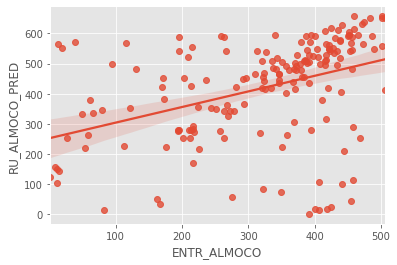

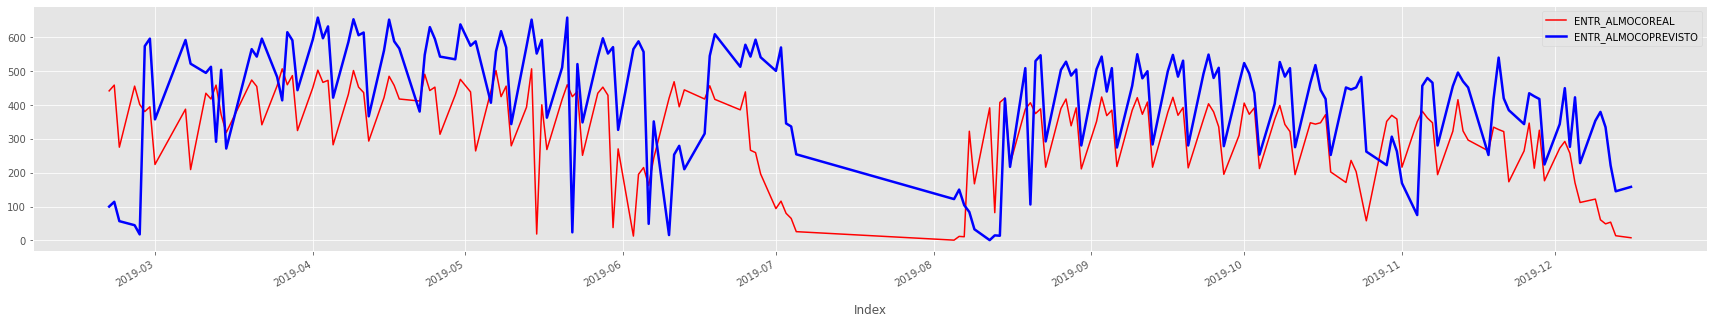

TOTAL DE REFEIÇÕES CONSUMIDAS = 30346 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 39465 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.47671279809529504 Pi (p) :1.0254810102831271e-11
RMSE = 122.13199938887955
TOTAL DE REFEIÇÕES SUB PROJETADAS = -13615
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 4496
ERRO ABSOLUTO MEDIANO = 87.5
ERRO ABSOLUTO PERCENTUAL MEDIO = 4510989187.37504%


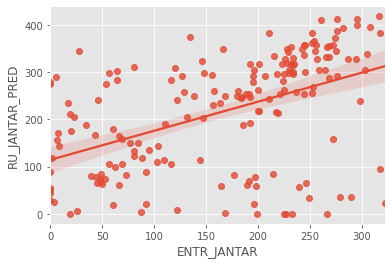

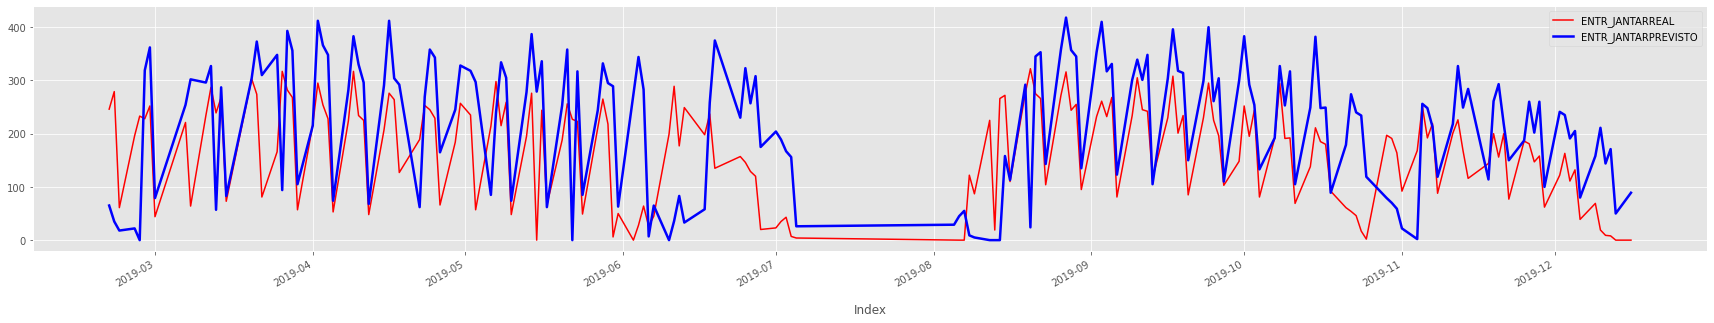

FEATURES CATEGORICAS, 0 = AUSENTE, 1 = PRESENTE
COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 5 DIAS ANTERIORES
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 59616 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.51110877997922 Pi (p) :3.188952457217921e-11
RMSE = 324.9878376102629
TOTAL DE REFEIÇÕES SUB PROJETADAS = -26500
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 6346
ERRO ABSOLUTO MEDIANO = 161.5
ERRO ABSOLUTO PERCENTUAL MEDIO = 139.6660008467958%


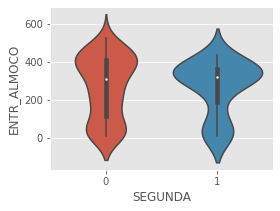

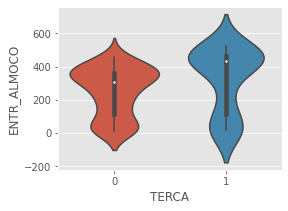

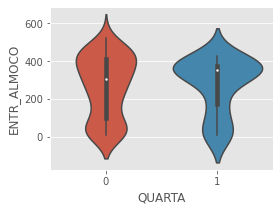

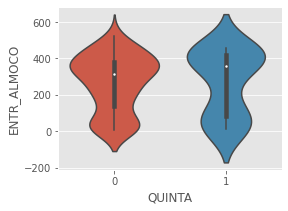

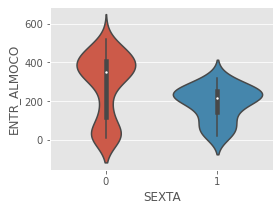

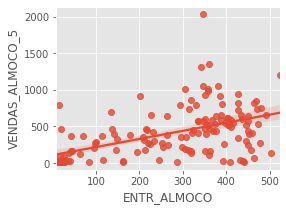

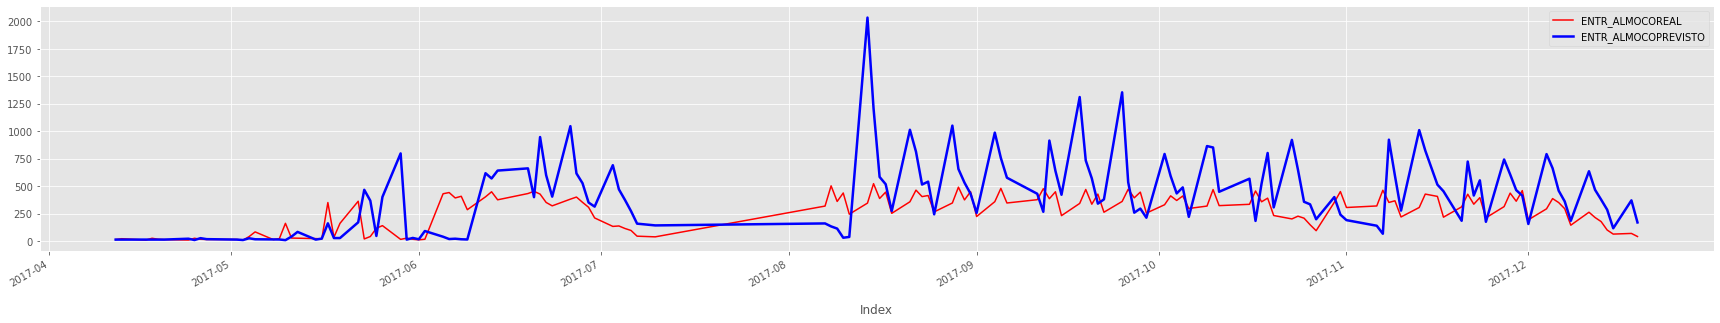

COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 1 DIA ANTERIOR
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 59932 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.7352359050337574 Pi (p) :1.9589327024897987e-26
RMSE = 284.49932313603995
TOTAL DE REFEIÇÕES SUB PROJETADAS = -23923
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 3453
ERRO ABSOLUTO MEDIANO = 119.5
ERRO ABSOLUTO PERCENTUAL MEDIO = 105.38309267799745%


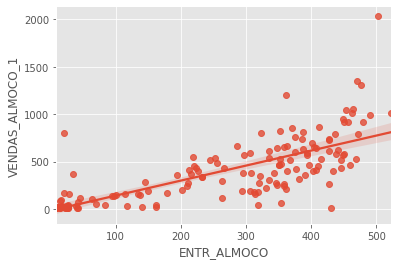

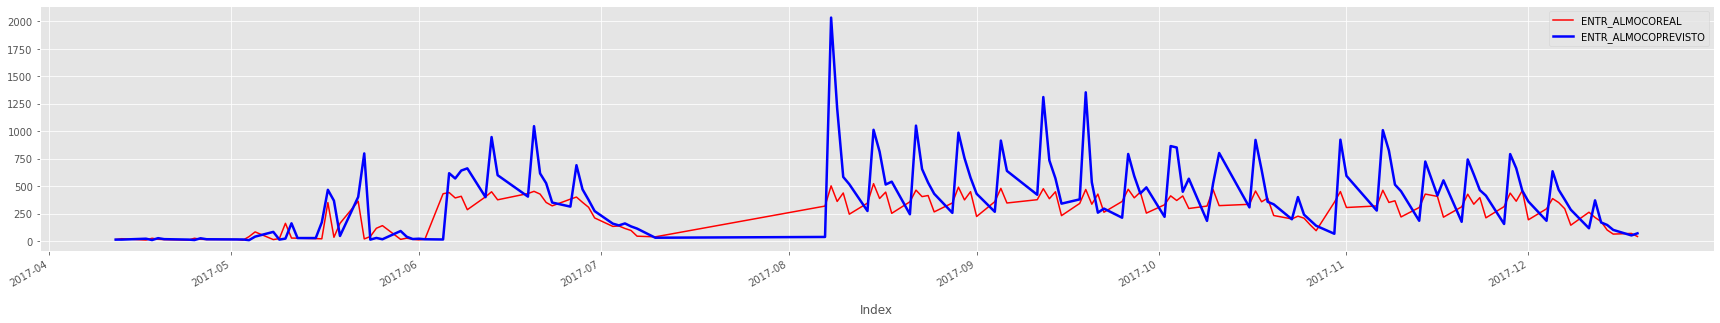

COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 2 DIAS ANTERIORES
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 59875 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.5114577994519922 Pi (p) :3.076423409203479e-11
RMSE = 324.2782526398203
TOTAL DE REFEIÇÕES SUB PROJETADAS = -27126
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 6713
ERRO ABSOLUTO MEDIANO = 188.0
ERRO ABSOLUTO PERCENTUAL MEDIO = 117.26486261681646%


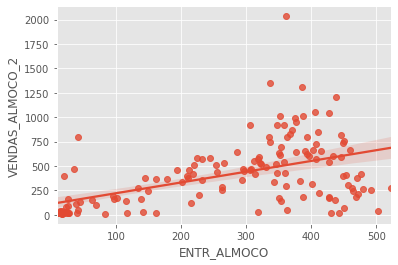

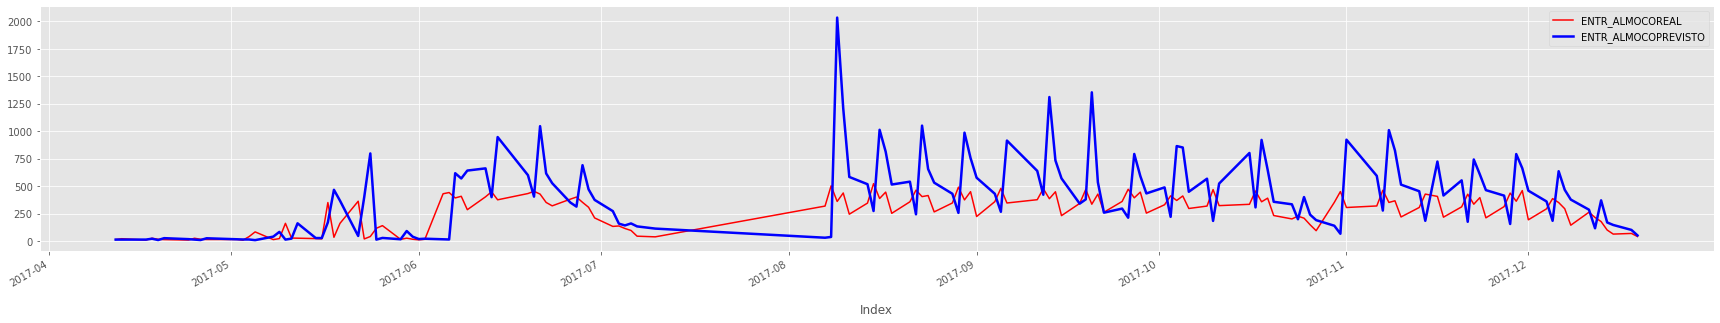

COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO SEMESTRE
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 8480.26 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): -0.23164127664086775 Pi (p) :0.0046145391079987896
RMSE = 267.5803559099937
TOTAL DE REFEIÇÕES SUB PROJETADAS = -1141.71
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 32123.449999999997
ERRO ABSOLUTO MEDIANO = 251.89
ERRO ABSOLUTO PERCENTUAL MEDIO = 101.60130833862038%


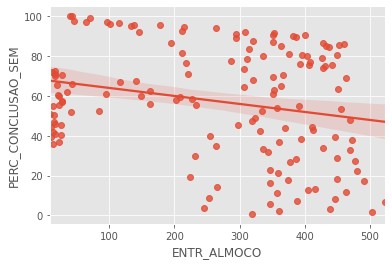

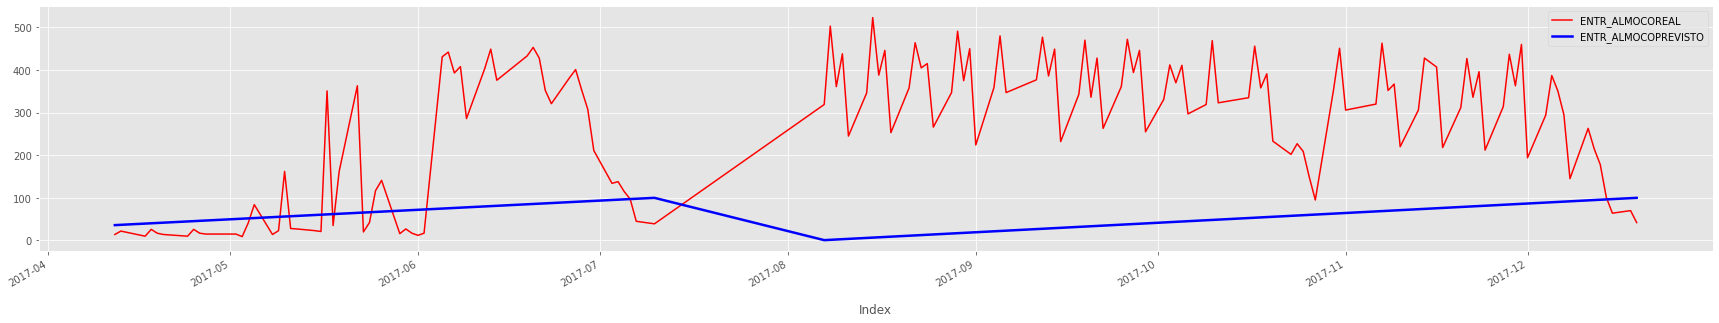

COMPORTAMENTO DE VENDAS EM RELAÇÃO AO AVANÇO DO MÊS
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 7786.42 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.0736522344856367 Pi (p) :0.37366466457036746
RMSE = 266.3964467896713
TOTAL DE REFEIÇÕES SUB PROJETADAS = -954.9899999999999
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 32630.569999999996
ERRO ABSOLUTO MEDIANO = 264.5
ERRO ABSOLUTO PERCENTUAL MEDIO = 103.84995887732116%


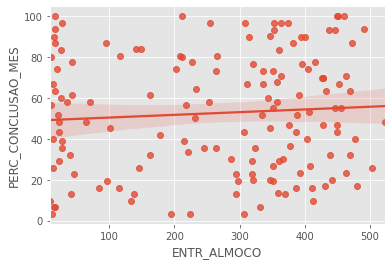

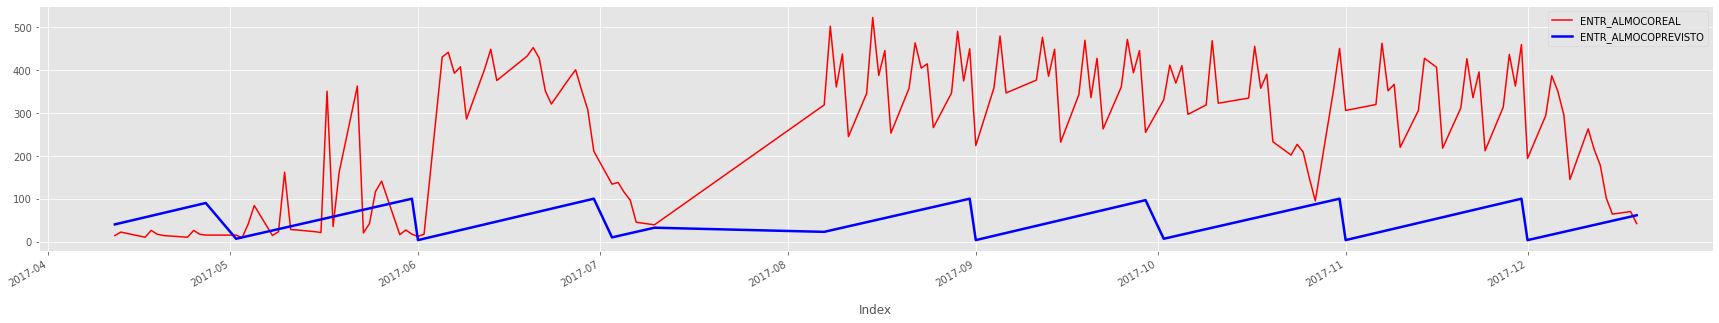

TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 252 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.011303745928493909 Pi (p) :0.891541147455103
RMSE = 308.54799442690415
TOTAL DE REFEIÇÕES SUB PROJETADAS = 0
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 39210
ERRO ABSOLUTO MEDIANO = 313.0
ERRO ABSOLUTO PERCENTUAL MEDIO = 97.55988635417036%


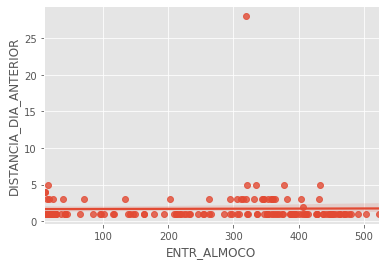

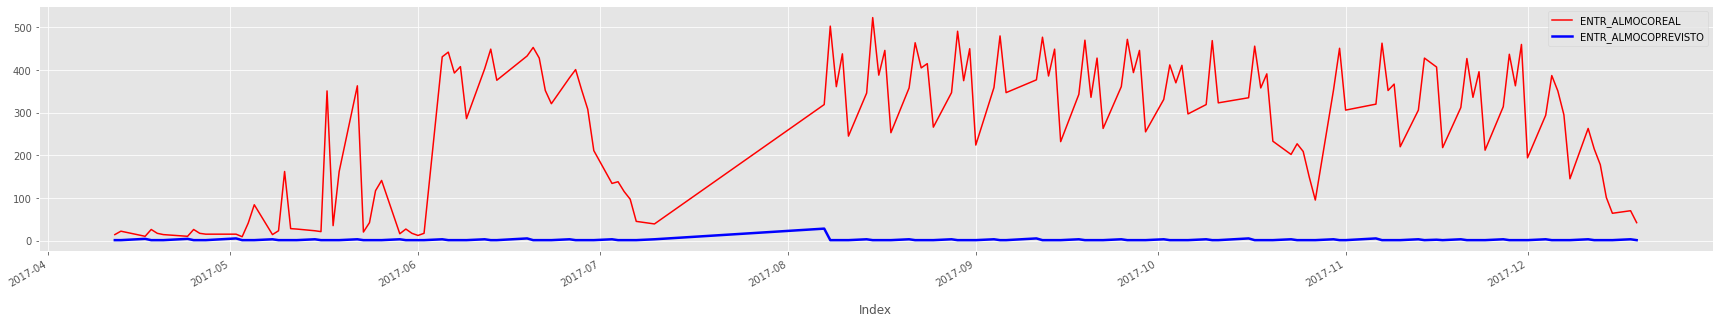

COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO POSTERIOR
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 320 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): -0.1884563175306126 Pi (p) :0.02180060331463528
RMSE = 308.79782155092124
TOTAL DE REFEIÇÕES SUB PROJETADAS = -27
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 39169
ERRO ABSOLUTO MEDIANO = 318.0
ERRO ABSOLUTO PERCENTUAL MEDIO = 97.14470944247493%


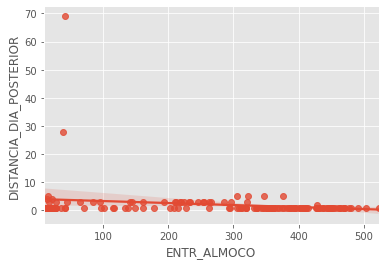

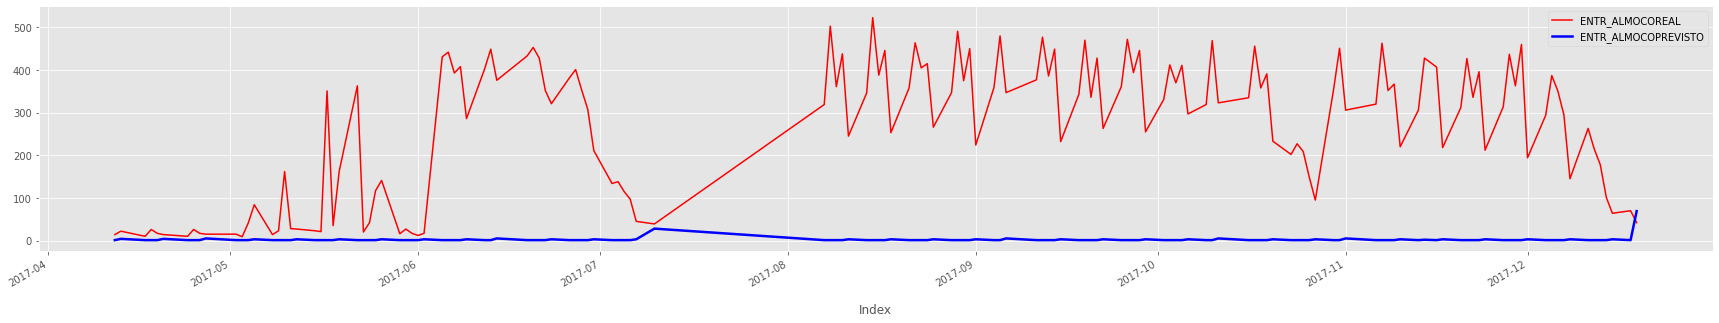

COMPORTAMENTO DE VENDAS EM RELAÇÃO À JANTA (CONSUMIDA) DE 1 DIA LETIVO ANTERIOR
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 20128 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.7887808764077484 Pi (p) :1.1547739837008958e-32
RMSE = 164.61544047641232
TOTAL DE REFEIÇÕES SUB PROJETADAS = -215
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 19549
ERRO ABSOLUTO MEDIANO = 121.5
ERRO ABSOLUTO PERCENTUAL MEDIO = 64.01093274855374%


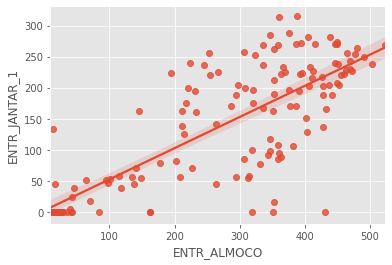

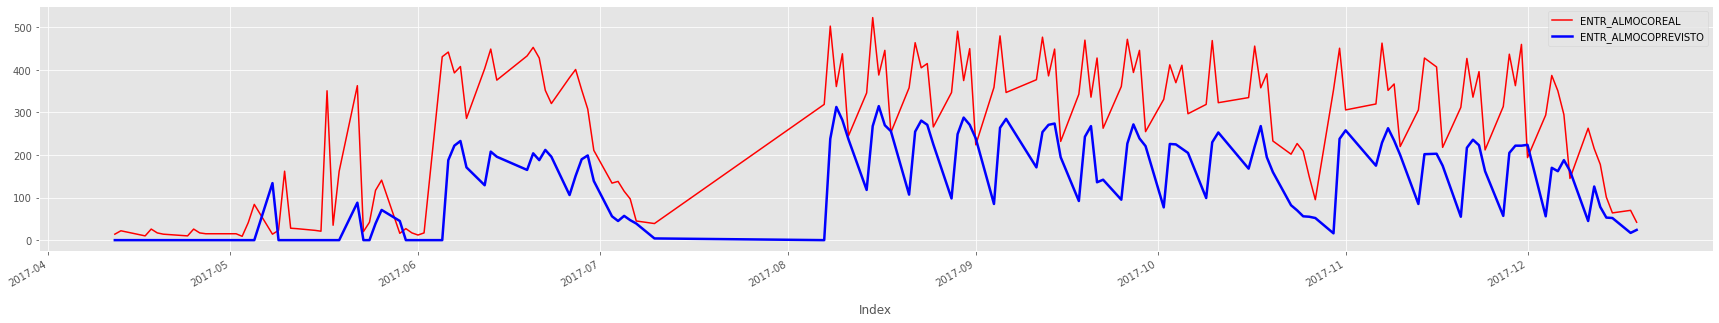

COMPORTAMENTO DE VENDAS EM RELAÇÃO À PRESSAO ATMOSFÉRICA
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 140448.59999999998 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): -0.00946538861255786 Pi (p) :0.9090969976717768
RMSE = 700.5427479866999
TOTAL DE REFEIÇÕES SUB PROJETADAS = -100986.59999999995
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 0
ERRO ABSOLUTO MEDIANO = 627.95
ERRO ABSOLUTO PERCENTUAL MEDIO = 1215.9624291191196%


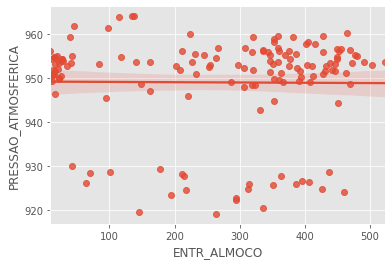

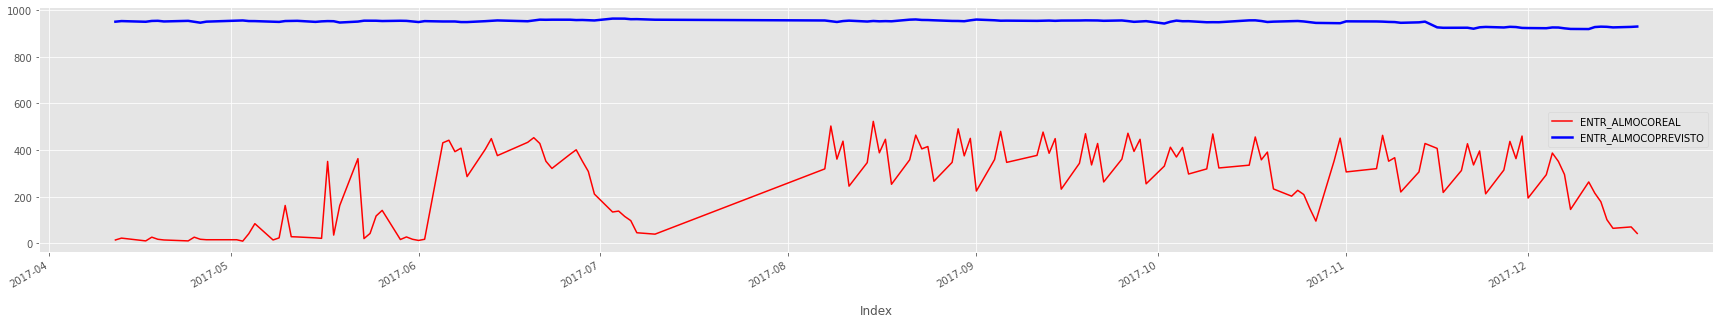

COMPORTAMENTO DE VENDAS EM RELAÇÃO À TEMPERATURA
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 2964.9000000000005 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.09570428754501267 Pi (p) :0.24724007502814532
RMSE = 292.8223053320904
TOTAL DE REFEIÇÕES SUB PROJETADAS = -78.6
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 36575.700000000026
ERRO ABSOLUTO MEDIANO = 294.65
ERRO ABSOLUTO PERCENTUAL MEDIO = 81.61299320981772%


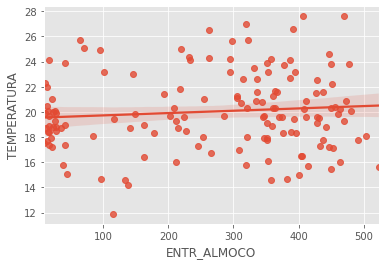

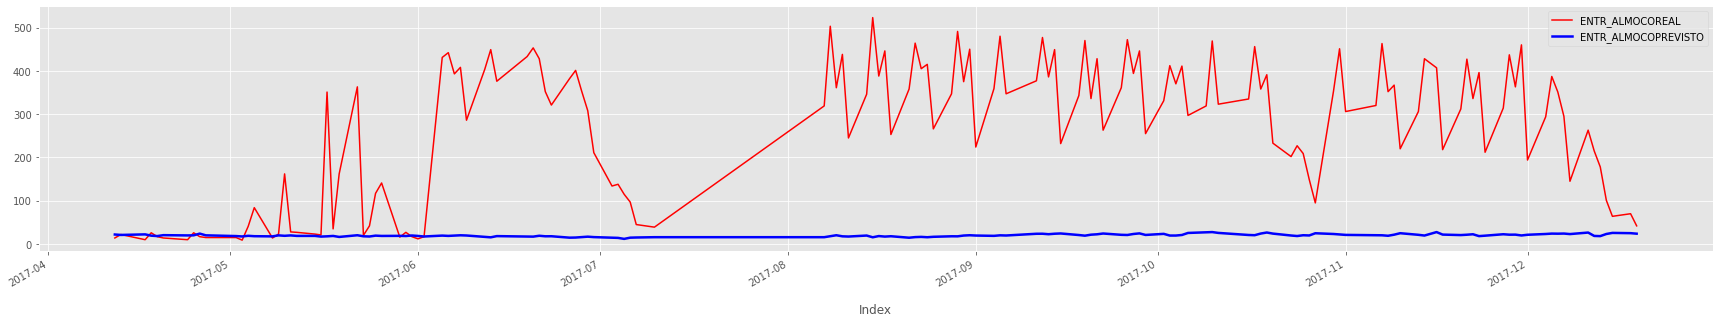

COMPORTAMENTO DE VENDAS EM RELAÇÃO AO VENTO
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 358.49999999999994 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.1161656050287295 Pi (p) :0.15972478997758147
RMSE = 307.8439194075728
TOTAL DE REFEIÇÕES SUB PROJETADAS = 0
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 39103.49999999999
ERRO ABSOLUTO MEDIANO = 313.45000000000005
ERRO ABSOLUTO PERCENTUAL MEDIO = 97.0096578253016%


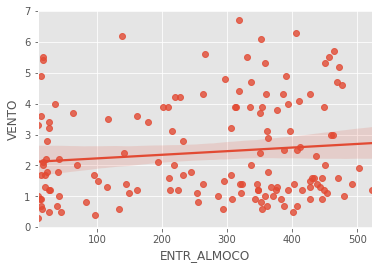

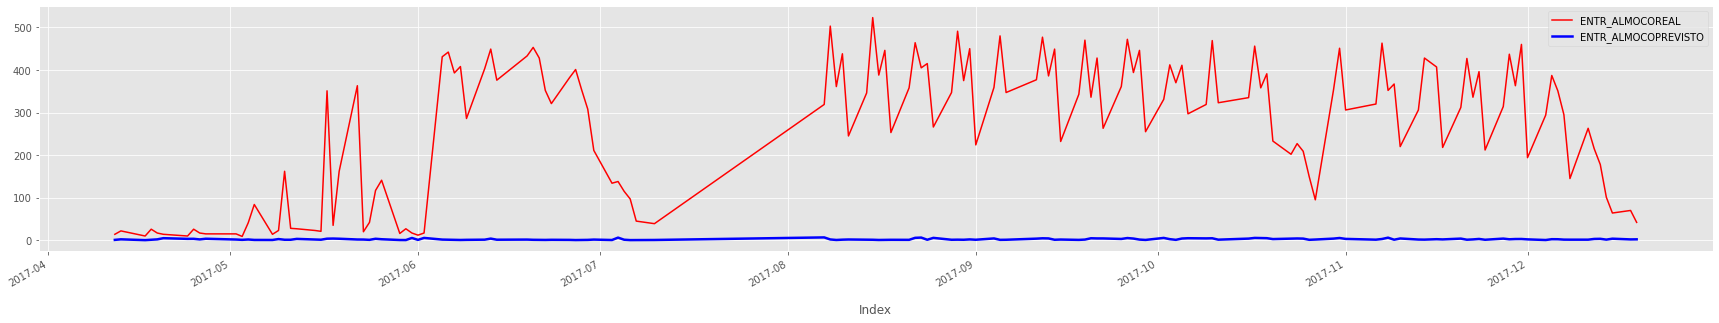

COMPORTAMENTO DE VENDAS EM RELAÇÃO À UMIDADE
TOTAL DE REFEIÇÕES CONSUMIDAS = 39462 : 148 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 10653 : 148 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): -0.21799878464837702 Pi (p) :0.00777531475604652
RMSE = 252.72489315780038
TOTAL DE REFEIÇÕES SUB PROJETADAS = -1655
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 30464
ERRO ABSOLUTO MEDIANO = 249.5
ERRO ABSOLUTO PERCENTUAL MEDIO = 122.83385339633494%


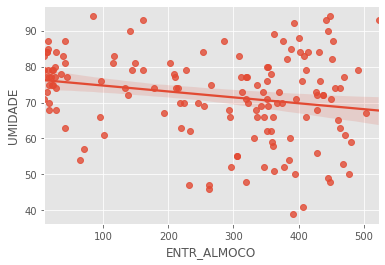

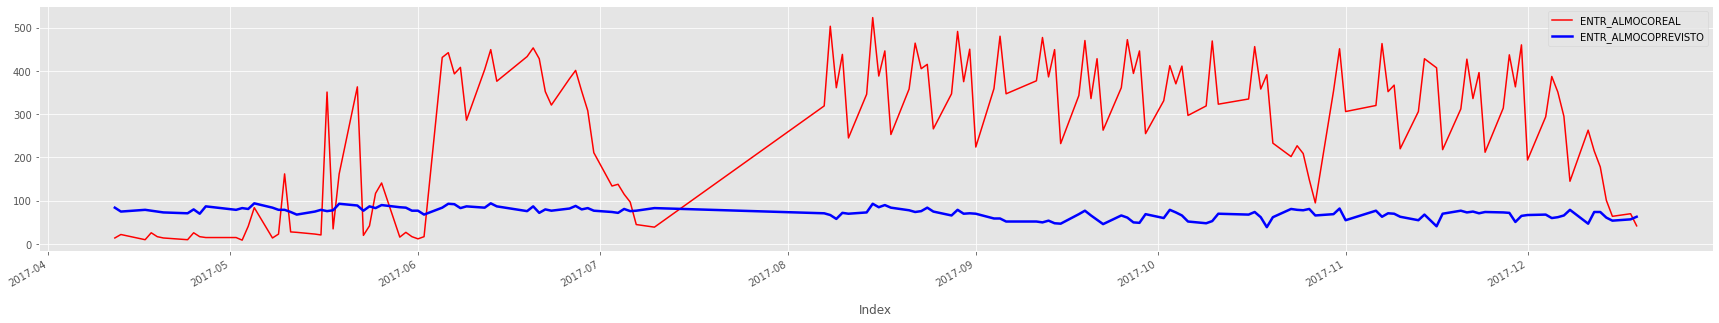

In [ ]:
#%% md

# TECNICA DO R.U, ANÁLISE DA 5A ÚLTIMA VENDA - CONJUNTO DE TESTE

#%% PREVISÃO DO R.U - CALCULO DO ALMOÇO

df_models_metrics2 = pd.DataFrame()

factor = 0.3
df_test['RU_ALMOCO_PRED'] = df_test.apply(lambda row: ru_pred_almoco(row,factor), axis=1)

#%% PREVISÃO DO R.U - CALCULO DO JANTAR

factor = 0.3
df_test['RU_JANTAR_PRED'] = df_test.apply(lambda row: ru_pred_jantar(row,factor), axis=1)

#%% PREVISÃO DO R.U - AVALIAÇÃO ALMOÇO

df_models_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'RU_ALMOCO_PRED',df_models_metrics2)

#%% PREVISÃO DO R.U - AVALIAÇÃO JANTAR

df_models_metrics = avaliacao_predicoes(df_test,'ENTR_JANTAR', 'RU_JANTAR_PRED',df_models_metrics2)

#%% md

# ANALISANDO AS FEATURES DO DATASET

#%% md

## ANÁLISES DAS FEATURES CATEGORICAS

#%%

print('FEATURES CATEGORICAS, 0 = AUSENTE, 1 = PRESENTE')
plt.figure(figsize=(4,3))
sns.violinplot(x='SEGUNDA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='TERCA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='QUARTA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='QUINTA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))
sns.violinplot(x='SEXTA',y='ENTR_ALMOCO',data=df_train)
plt.figure(figsize=(4,3))


#%% md

## ANÁLISES DAS FEATURES QUATITATIVAS

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 5 DIAS ANTERIORES')
VENDAS_ALMOCO_5_metrics = []
VENDAS_ALMOCO_5_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENDAS_ALMOCO_5',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 1 DIA ANTERIOR')
VENDAS_ALMOCO_1_metrics = []
VENDAS_ALMOCO_1_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENDAS_ALMOCO_1',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO ÀS VENDAS DE 2 DIAS ANTERIORES')
VENDAS_ALMOCO_2_metrics = []
VENDAS_ALMOCO_2_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENDAS_ALMOCO_2',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO SEMESTRE

print('COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO SEMESTRE')
PERC_CONCLUSAO_SEM_metrics = []
PERC_CONCLUSAO_SEM_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'PERC_CONCLUSAO_SEM',df_models_metrics2)

#%% COMPORTAMENTO DE CONSUMO EM RELAÇÃO AO AVANÇO DO MÊS

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO AO AVANÇO DO MÊS')
PERC_CONCLUSAO_MES_metrics = []
PERC_CONCLUSAO_MES_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'PERC_CONCLUSAO_MES',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO ANTERIOR

ENTR_ALMOCO_metrics = []
ENTR_ALMOCO_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'DISTANCIA_DIA_ANTERIOR',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO ANTERIOR

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À DISTANCIA EM DIAS PARA 1 DIA LETIVO POSTERIOR')
DISTANCIA_DIA_POSTERIOR = []
DISTANCIA_DIA_POSTERIOR = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'DISTANCIA_DIA_POSTERIOR',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À JANTA (CONSUMIDA) DE 1 DIA LETIVO ANTERIOR

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À JANTA (CONSUMIDA) DE 1 DIA LETIVO ANTERIOR')
ENTR_JANTAR_1_metrics = []
ENTR_JANTAR_1_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'ENTR_JANTAR_1',df_models_metrics2)


#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À PRESSAO ATMOSFÉRICA

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À PRESSAO ATMOSFÉRICA')
PRESSAO_ATMOSFERICA_metrics = []
PRESSAO_ATMOSFERICA_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'PRESSAO_ATMOSFERICA',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À TEMPERATURA

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À TEMPERATURA')
TEMPERATURA_metrics = []
TEMPERATURA_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'TEMPERATURA',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO AO VENTO

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO AO VENTO')
VENTO_metrics = []
VENTO_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'VENTO',df_models_metrics2)

#%% COMPORTAMENTO DE VENDAS EM RELAÇÃO À UMIDADE

print('COMPORTAMENTO DE VENDAS EM RELAÇÃO À UMIDADE')
UMIDADE_metrics = []
UMIDADE_metrics = avaliacao_predicoes(df_train,'ENTR_ALMOCO', 'UMIDADE',df_models_metrics2)

#### **FORMATANDO FEATURES TEMPORAIS PARA SHAPE COMPATÍVEL COM REDES RECORRENTES**
shape = (num_samples,   num_lags_passados,   num_features)

In [ ]:
# pegando features temporais
# IMPORTANTE ESTAR EM ORDEM !! PRIMEIRO ELEMENTO = Y E OS DEMAIS = X0, X1, ...
feature_0 = ['ENTR_ALMOCO', 'ENTR_ALMOCO_1', 'ENTR_ALMOCO_2','ENTR_ALMOCO_3', 'ENTR_ALMOCO_4', 'ENTR_ALMOCO_5',]
feature_1 = ['VENDAS_ALMOCO','VENDAS_ALMOCO_1','VENDAS_ALMOCO_2','VENDAS_ALMOCO_3','VENDAS_ALMOCO_4','VENDAS_ALMOCO_5']
feature_2 = ['ENTR_JANTAR','ENTR_JANTAR_1', 'ENTR_JANTAR_2', 'ENTR_JANTAR_3', 'ENTR_JANTAR_4','ENTR_JANTAR_5']
features_temporais = [feature_0, feature_1, feature_2]
##################################################
feature_to_predict = 0 # ENTR_ALMOCO, feature 0 que será o valor da saída do modelo (trocar se quiser)
##################################################
num_temporais = len(features_temporais) # 3 séries temporais


train_x, train_y = [], []
val_x, val_y = [], []
test_x, test_y = [], []
# serapando em dfs com somente uma feature
for feature_cols in features_temporais:
    # train
    x, y = to_supervised_numpy(df_train[feature_cols], feature_cols[0]) # feature[0] = ENTR_ALMOCO = y!!! IMPORTANTE  
    train_x.append(x); train_y.append(y)
    # validacao
    x, y = to_supervised_numpy(df_val[feature_cols], feature_cols[0]) # feature[0] = VENDAS_ALMOCO = y!!! IMPORTANTE  
    val_x.append(x); val_y.append(y)
    # test
    x, y = to_supervised_numpy(df_test[feature_cols], feature_cols[0]) # feature[0] = ENTR_JANTAR = y !!! IMPORTANTE  
    test_x.append(x); test_y.append(y)

    
# transforma em numpy array
train_x = np.array(train_x);  train_y = np.array(train_y); 
val_x = np.array(val_x);  val_y = np.array(val_y); 
test_x = np.array(test_x);  test_y = np.array(test_y); 
#
print('shape treino:', val_x.shape, val_y.shape)
print('shape validacao:', train_x.shape, train_y.shape)
print('shape teste:', test_x.shape, test_y.shape)

shape treino: (3, 184, 5) (3, 184)
shape validacao: (3, 148, 5) (3, 148)
shape teste: (3, 182, 5) (3, 182)


#### **TRATAMENTO DE OUTLIERS NAS FEATURES TEMPORAIS**
verifica se é distante da média

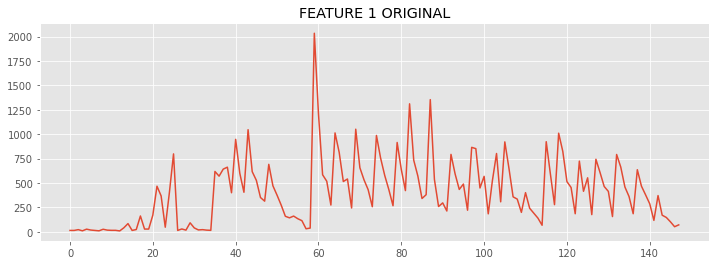

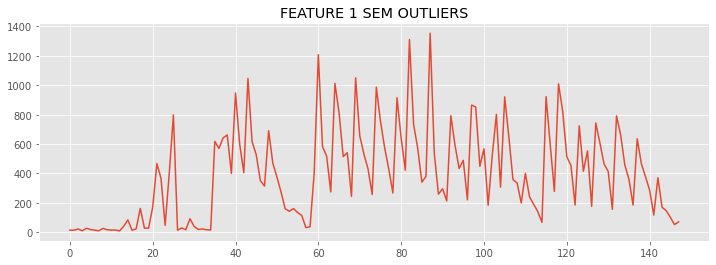

5 outliers  aredondados para a media


In [ ]:
TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS = True
tolerancia_sigma = 3
num_outliers = 0
if TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS:
    plot_serie(train_x[1, :, 0], title='FEATURE 1 ORIGINAL')
    num_outliers = 0
    for feature_i in range(num_temporais):
        desvio_padrao = np.std(train_x[feature_i, :, 0])
        media = np.mean(train_x[feature_i, :, 0])
        for lag_i in range(train_x.shape[2]):
            for element_i in range(train_x.shape[1]):
                valor = train_x[feature_i, element_i, lag_i]
                if np.abs(valor - media) >= tolerancia_sigma*desvio_padrao:
                    train_x[feature_i, element_i, lag_i] = media
                    num_outliers += 1
    
    plot_serie(train_x[1, :, 0], title='FEATURE 1 SEM OUTLIERS')
    print(num_outliers, 'outliers  aredondados para a media')

#### **ESCALONANDO FEATURES TEMPORAIS (MINMAX SCALER)**

Criados 3 scalers para as features temporais
(3, 5, 148, 1) (3, 148, 1)
(3, 5, 184, 1) (3, 184, 1)
(3, 5, 182, 1) (3, 182, 1)


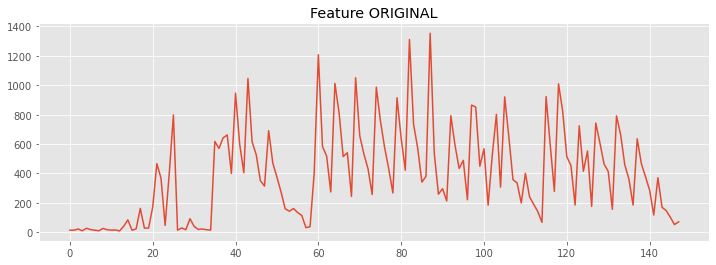

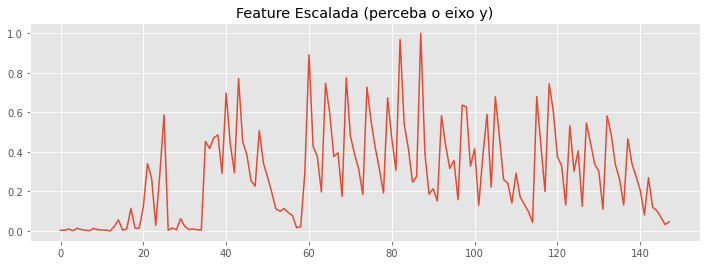

In [ ]:
#
# o correto seria escalonar antes de dividir em lags mas como ja foi dividido sera preciso
# fazer dessa forma não muito otimizada
# escalando features
scalers = [MinMaxScaler([0,1]) for i in range(num_temporais)] # Um scaler para cada feature TEMPORAL
print('Criados', len(scalers),'scalers para as features temporais')

# nao é a maneira mais eficiente, mas é a mais facil de implementar nessas condicoes

def treina_scalers(train_x):
    for i in range(len(train_x)): # pra cada feature
        feature_x = train_x[i]
        scalers[i].fit(feature_x[:, 0].reshape(-1,1)) # poderia usar qualquer coluna(lag), usando a primeira aqui
#     
def scala_features(data_x, data_y):
    scaled_data_x, scaled_data_y = [], []
    for feature_i in range(len(data_x)): # pra cada feature
        x = data_x[feature_i]; y = data_y[feature_i].reshape(-1, 1)
        scaled_x = []
        # pra cada lag, aplicar transform depois de ter 'treinado' o scaler(calculado parametros media etc)
        for lag in range(x.shape[1]): # x.shape[1] = numero de lags (nesse caso 5)
            lag_scaled = scalers[feature_i].transform(x[:, lag].reshape(-1,1)) # lag atual, ENTR_JANTAR_'lag' por exemplo
            scaled_x.append(lag_scaled) # adiciona cada lag no vetor de retorno, lag_1, lag_2 .. lag_5
        # scaled_x = vetor de lags para a feature do for mais externo, feature de indice feature_i
        scaled_data_x.append(np.array(scaled_x))
        scaled_data_y.append(scalers[feature_i].transform(y))
    return np.array(scaled_data_x), np.array(scaled_data_y)


# treina
treina_scalers(train_x) # treina os scalers para depois usar
# fit transform
scaled_train_x, scaled_train_y = scala_features(train_x, train_y)
scaled_val_x, scaled_val_y = scala_features(val_x, val_y)
scaled_test_x, scaled_test_y = scala_features(test_x, test_y)


# (num_features, num_lags, num_samples, 1) e (num_features, num_samples, 1)
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)

#
feature_para_ver = 1
plot_serie(train_x[feature_para_ver, :, 0], title='Feature ORIGINAL')
plot_serie(scaled_train_x[feature_para_ver, 0, :, 0], title='Feature Escalada (perceba o eixo y)')


#### **TRANSPONDO MATRIZES (SÓ UMA CONVENÇÃO, NÃO ALTERA NADA)**
Transpõe matrizes para ordem correta dos eixos
* Shape de Antes: **data_X:(num_features, num_lags, num_instancias, 1) data_Y:(num_features, num_instancias, 1)**
* Shape de Depois: **data_X:(num_instancias, num_lags, num_features) data_Y:(num_instancias, num_features)**

In [ ]:
def transpose_to_rnn(data_x, data_y): # faz a transposição (necessario devido ao problema citado acima)
    data_x = data_x.transpose(2, 1, 0, 3)
    data_y = data_y.transpose(1, 0, 2)
    data_x = np.squeeze(data_x) # remove ultima dimensão desnecessaria()
    data_y = np.squeeze(data_y) # remove ultima dimensão desnecessaria()

    return data_x, data_y
# sobreescreve matrizes , portanto executar uma única vez
scaled_train_x, scaled_train_y = transpose_to_rnn(scaled_train_x, scaled_train_y)
scaled_val_x, scaled_val_y = transpose_to_rnn(scaled_val_x, scaled_val_y)
scaled_test_x, scaled_test_y = transpose_to_rnn(scaled_test_x, scaled_test_y)
#
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)
#

(148, 5, 3) (148, 3)
(184, 5, 3) (184, 3)
(182, 5, 3) (182, 3)


#### **REMOVENDO Y QUE NÃO QUEREMOS PREVER DAS FEATURES TEMPORAIS(JANTA POR EXEMPLO)**


In [ ]:
# os vetores train_y, val_y e test_y possuem o y para todas as features
# porém queremos prever somente uma delas (saida da rede pode ser as tres caso quisermos)
# portanto vamos retirar as outras dos vetores y

# dados originais
train_y = train_y[feature_to_predict,:]
val_y = val_y[feature_to_predict,:]
test_y = test_y[feature_to_predict,:]
# dados escalados
scaled_train_y = scaled_train_y[:, feature_to_predict]
scaled_val_y = scaled_val_y[:, feature_to_predict]
scaled_test_y = scaled_test_y[:, feature_to_predict]
print(scaled_train_y.shape)
print(scaled_val_y.shape)
print(scaled_test_y.shape)

(148,)
(184,)
(182,)


#### **SEPARA FEATURES NÃO TEMPORAIS (ONE HOT E NUMERICAS)**


In [ ]:
# features one hot
features_categoricas = ['SEMESTRE_1', 'SEMESTRE_2']
# divide df completo
train_x_cat = df_train[features_categoricas].values
val_x_cat = df_val[features_categoricas].values
test_x_cat = df_test[features_categoricas].values
print('features categoricas one_hot: ',train_x_cat.shape, val_x_cat.shape, test_x_cat.shape)




#features numericas pontuais
features_numericas_pontuais = ['DISTANCIA_DIA_ANTERIOR', 'DISTANCIA_DIA_POSTERIOR',
       'PERC_CONCLUSAO_SEM', 'PERC_CONCLUSAO_MES', 'PRESSAO_ATMOSFERICA',
       'TEMPERATURA', 'UMIDADE', 'VENTO']
# divide df completo
train_x_numpont = df_train[features_numericas_pontuais].values
val_x_numpont = df_val[features_numericas_pontuais].values
test_x_numpont = df_test[features_numericas_pontuais].values
print('features numericas pontuais:', train_x_numpont.shape, val_x_numpont.shape, test_x_numpont.shape)

features categoricas one_hot:  (148, 2) (184, 2) (182, 2)
features numericas pontuais: (148, 8) (184, 8) (182, 8)


#### **ESCALA FEATURES NÃO TEMPORAIS E COMPACTA EM UM UNICO VETOR**


In [ ]:
# scaler das features numericas não temporais (temperatura, umidade etc) 
# nesse caso pode usar um unico scaler (ele cria diferentes estatisticas para cada feature)
scaler_numpont = MinMaxScaler([0,1]).fit(train_x_numpont)
train_x_numpont = scaler_numpont.transform(train_x_numpont)
val_x_numpont = scaler_numpont.transform(val_x_numpont)
test_x_numpont = scaler_numpont.transform(test_x_numpont)

# concatena tudo pra alimentar parte densa do modelo
train_x_dense = np.hstack([train_x_numpont, train_x_cat])
val_x_dense = np.hstack([val_x_numpont, val_x_cat])
test_x_dense = np.hstack([test_x_numpont, test_x_cat])

print('treino', train_x_dense.shape)
print('validacao', val_x_dense.shape)
print('teste', test_x_dense.shape)

treino (148, 10)
validacao (184, 10)
teste (182, 10)


In [ ]:
# RESULTADO 
print(scaled_train_x.shape, ' e ', train_x_dense.shape)

(148, 5, 3)  e  (148, 10)


# **Definição e Treino de Modelos**

## EXPLORANDO O PROBLEMA (RODAR PRIMEIROS TREINOS)
 CRIAR UMA MLP PADRÃO (1 CAMADA 1 SAÍDA), CHEGANDO NELA TODAS AS FEATURES ESCALADAS
 DEIXA-LA PREPARADA PARA SER USADA PARA PREVISÕES ASSIM COMO AS OUTRAS
 ESTA MLP SERÁ USADA PARA EXPLORAR O DOMÍNIO DO PROBLEMA E REALIZAR PRIMEIROS TREINOS. 
 O MAIS IMPORTANTE AQUI É TER O DATASET CHEGANDO INTEIRO E ESCALADO.

In [ ]:
num_lags = scaled_train_x.shape[1] # = 5 #JANELA TEMPORAL
num_features = scaled_train_x.shape[2] # = 3 #NUMERO DE FEATURES (VENDA_ALMOCO,ENTR_ALMOCO,ENTR_JANTAR)
num_output = 1 # ENTR_ALMOCO
learning_rate = 0.001 # bom valor
feature_to_predict = 0 #ENTR_ALMOCO

In [ ]:
#%%
###################### modelo MLP com uma única camada
current_model = 'MLP1'
MLP1 = keras.Sequential()
MLP1.add(layers.Flatten(input_shape=(num_lags, num_features),))
#model_mlp_unique_1.add(layers.Dense(64, activation='relu'))
#model_mlp_unique_1.add(layers.Dense(32, activation='relu'))
MLP1.add(layers.Dense(1, activation='relu'))
MLP1.add(layers.Dense(num_output, activation='linear'))
MLP1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.MeanAbsolutePercentageError(),keras.losses.mean_squared_error])
keras.utils.plot_model(MLP1, show_shapes=True)
MLP1.save_weights(prefix + current_model + "_wheigts_initial.h5")
######################

(148, 5, 3) (148,)


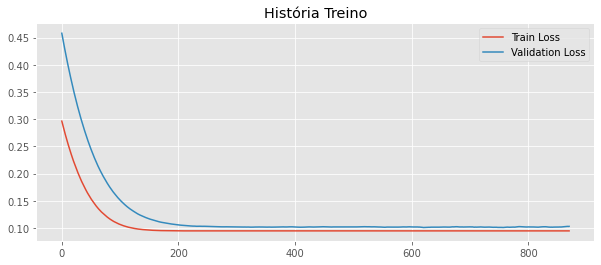

In [ ]:
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = MLP1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

In [ ]:
pred_y1 = MLP1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y1 = scalers[feature_to_predict].inverse_transform(pred_y1)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 49193.1 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): nan Pi (p) :nan
RMSE = 163.16736832676332
TOTAL DE REFEIÇÕES SUB PROJETADAS = -4920.861755371094
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 21364.75311279297
ERRO ABSOLUTO MEDIANO = 145.64614868164062
ERRO ABSOLUTO PERCENTUAL MEDIO = 2906020198.817707%


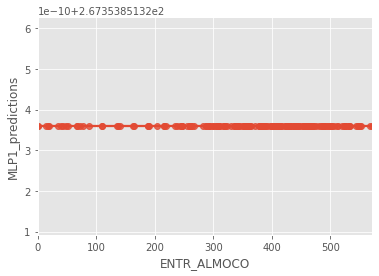

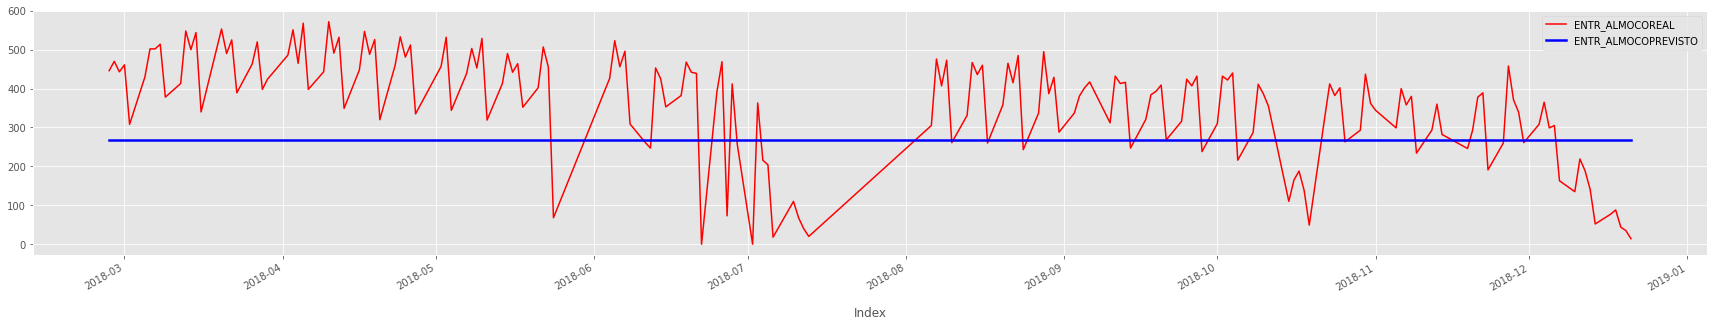

In [ ]:
import scipy
import seaborn as sns
df_val['MLP1_predictions'] = pred_y1
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'MLP1_predictions',df_models_metrics)

In [ ]:
df_models_metrics

CORRELACAO  ...            pi
RU_JANTAR_PRED      0.476713  ...  1.025481e-11
MLP1_predictions         NaN  ...           NaN

[2 rows x 11 columns]

In [ ]:
#%%
###################### modelo MLP 2 com mais camadas
current_model = 'MLP2'
MLP2 = keras.Sequential()
MLP2.add(layers.Flatten(input_shape=(num_lags, num_features),))
MLP2.add(layers.Dense(15, activation='relu'))
MLP2.add(layers.Dense(5, activation='relu'))
MLP2.add(layers.Dense(1, activation='relu'))
MLP2.add(layers.Dense(num_output, activation='linear'))
MLP2.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(MLP2, show_shapes=True)
MLP2.save_weights(prefix + current_model + "_wheigts_initial.h5")
######################

(148, 5, 3) (148,)


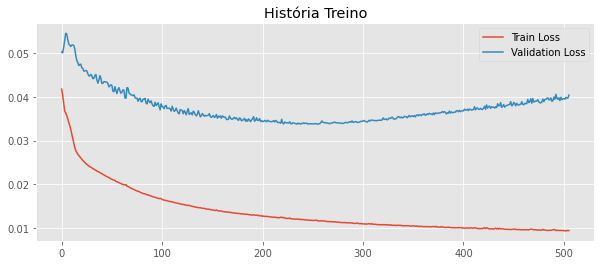

In [ ]:
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = MLP2.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 64004.156 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.7315961879861969 Pi (p) :4.201675732044158e-32
RMSE = 94.42841509499434
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5377.99728012085
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 7010.841026306152
ERRO ABSOLUTO MEDIANO = 53.73976135253906
ERRO ABSOLUTO PERCENTUAL MEDIO = 3726138268.312753%


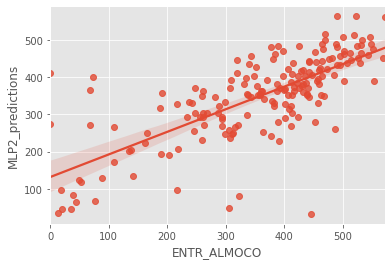

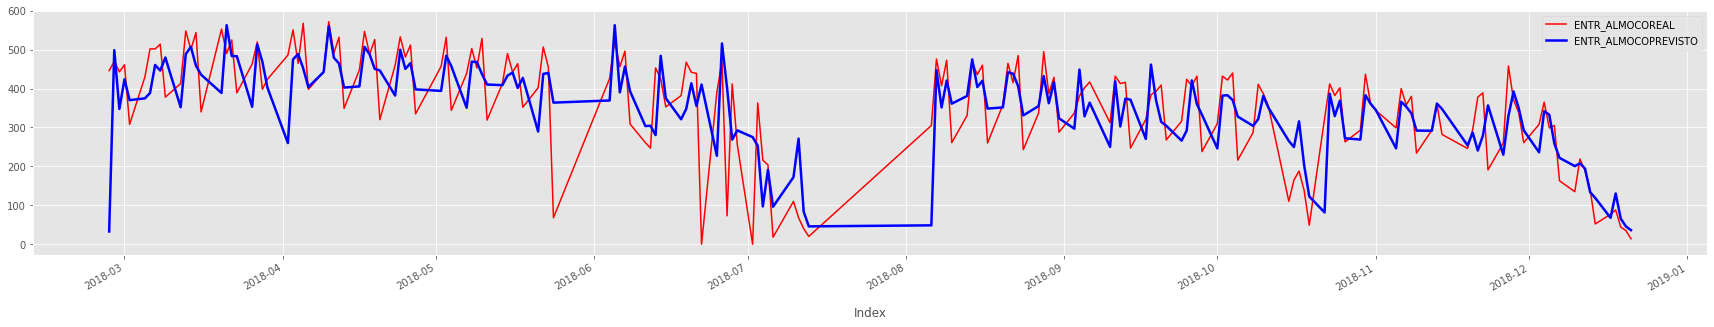

In [ ]:
#MLP2
pred_y2 = MLP2.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y2 = scalers[feature_to_predict].inverse_transform(pred_y2)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))

df_val['MLP2_predictions'] = pred_y2
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', 'MLP2_predictions',df_models_metrics)

In [ ]:
df_models_metrics

CORRELACAO  ...            pi
RU_JANTAR_PRED      0.476713  ...  1.025481e-11
MLP1_predictions         NaN  ...           NaN
MLP2_predictions    0.731596  ...  4.201676e-32

[3 rows x 11 columns]

In [ ]:
MLP1.save(prefix + 'MLP1' + "_validated.h5")
MLP2.save(prefix + 'MLP2' + "_validated.h5")

## **Modelos que usam somente dados endógenos**

In [ ]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_output = 1 # saída é um unico numero escalar
learning_rate = 0.001 # bom valor

### RNN_ENDO_1

In [ ]:
#model_rnn_unique_1
###################### modelo RNN com uma única camada 
RNN_ENDO_1 = keras.Sequential()
num_units = 16 # ajustavel
RNN_ENDO_1.add(layers.GRU(num_units, input_shape=(num_lags, num_features),))
RNN_ENDO_1.add(layers.Dense(num_output, activation='linear'))
RNN_ENDO_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(RNN_ENDO_1, show_shapes=True)
RNN_ENDO_1.save_weights(prefix + 'RNN_ENDO_1' + "_wheigts_initial.h5")
######################

### RNN_ENDO_2

In [ ]:
#model_rnn_unique_2
###################### modelo RNN com mais de uma camada
RNN_ENDO_2 = keras.Sequential()
num_units = 16 # ajustavel
num_units_2 = 8 # ajustavel
num_units_3 = 4 # ajustavel
RNN_ENDO_2.add(layers.GRU(num_units, input_shape=(num_lags, num_features), return_sequences=True)) # return_sequences=True
RNN_ENDO_2.add(layers.Dropout(0.2)) # não necessário porém é bom
RNN_ENDO_2.add(layers.GRU(num_units_2, return_sequences=True))
RNN_ENDO_2.add(layers.Dropout(0.2)) # não necessário porém é bom
RNN_ENDO_2.add(layers.GRU(num_units_3, return_sequences=False)) # return_sequences=False
RNN_ENDO_2.add(layers.Dense(num_output, activation='linear'))
RNN_ENDO_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(RNN_ENDO_2, show_shapes=True)
RNN_ENDO_2.save_weights(prefix + 'RNN_ENDO_2' + "_wheigts_initial.h5")
######################

### MLP_ENDO_1

In [ ]:
#model_mlp_unique_1
###################### modelo MLP com uma única camada
MLP_ENDO_1 = keras.Sequential()
MLP_ENDO_1.add(layers.Flatten(input_shape=(num_lags, num_features),))
MLP_ENDO_1.add(layers.Dense(64, activation='relu'))
MLP_ENDO_1.add(layers.Dense(32, activation='relu'))
MLP_ENDO_1.add(layers.Dense(num_output, activation='linear'))
MLP_ENDO_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(MLP_ENDO_1, show_shapes=True)
MLP_ENDO_1.save_weights(prefix + 'MLP_ENDO_1' + "_wheigts_initial.h5")
######################

###TREINO DOS MODELOS

###RNN_ENDO_1

(148, 5, 3) (148,)
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: case2_RNN_ENDO_1_trained/assets


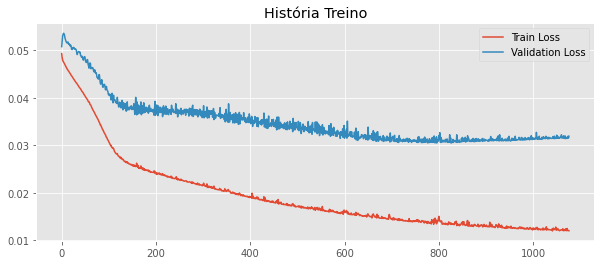

In [ ]:
#RNN_ENDO_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = RNN_ENDO_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)
RNN_ENDO_1.save(prefix + 'RNN_ENDO_1' + '_trained')

###RNN_ENDO_2

(148, 5, 3) (148,)
INFO:tensorflow:Assets written to: case2_RNN_ENDO_2_trained/assets


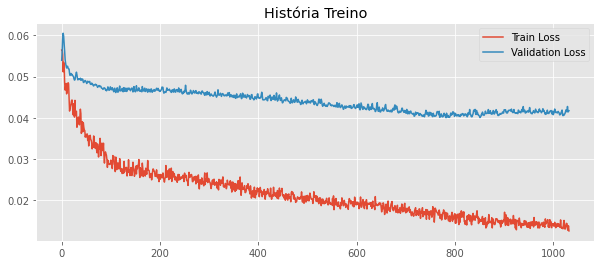

In [ ]:
#################################################################################
#################################################################################
#model_rnn_unique_2
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = RNN_ENDO_2.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)
RNN_ENDO_2.save(prefix + 'RNN_ENDO_2' + '_trained')

###MLP_ENDO_1

(148, 5, 3) (148,)
INFO:tensorflow:Assets written to: case2_MLP_ENDO_1_trained/assets


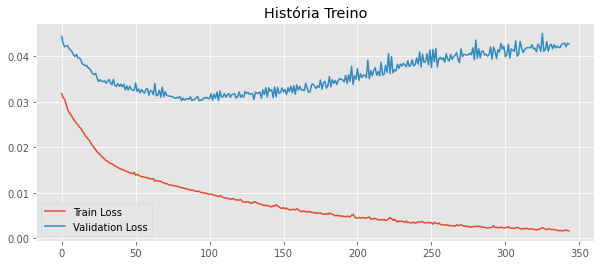

In [ ]:
#################################################################################
#################################################################################
#MLP_ENDO_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = MLP_ENDO_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)
MLP_ENDO_1.save(prefix + 'MLP_ENDO_1' + '_trained')

### **AVALIAÇÂO DO MODELO**

###RNN_ENDO_1

RMSE:  89.73281442880939


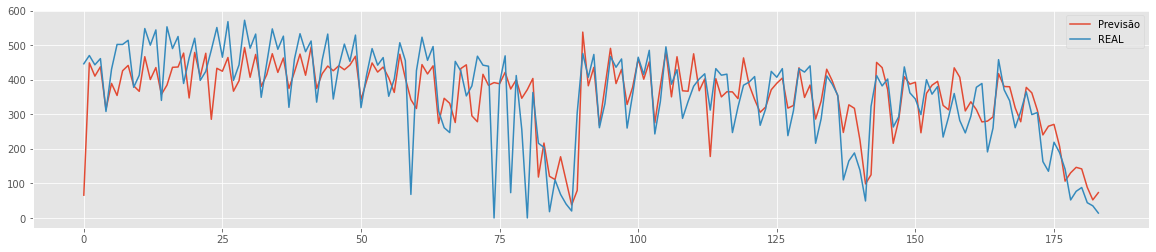

TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 65219.613 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.7538102329191316 Pi (p) :5.014834155014456e-35


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE = 89.73281442880939
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5666.187889099121
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 6083.576965332031
ERRO ABSOLUTO MEDIANO = 48.55305480957031
ERRO ABSOLUTO PERCENTUAL MEDIO = 4145884336.345922%


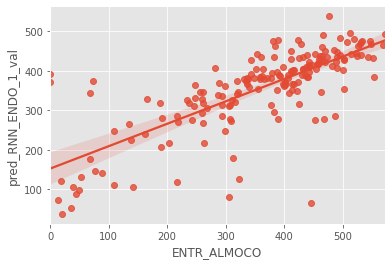

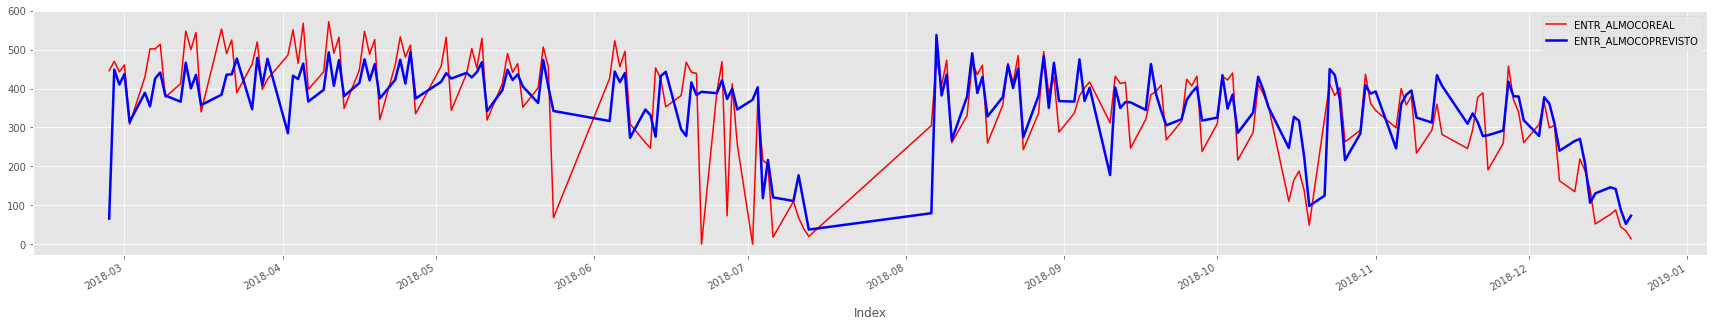

In [ ]:
#RNN_ENDO_1
model_name = 'RNN_ENDO_1'
model = RNN_ENDO_1
pred_y = model.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

In [ ]:
df_models_metrics

CORRELACAO  ...            pi
RU_JANTAR_PRED         0.476713  ...  1.025481e-11
MLP1_predictions            NaN  ...           NaN
MLP2_predictions       0.731596  ...  4.201676e-32
pred_RNN_ENDO_1_val    0.753810  ...  5.014834e-35

[4 rows x 11 columns]

###RNN_ENDO_2

RMSE:  102.80909876605612


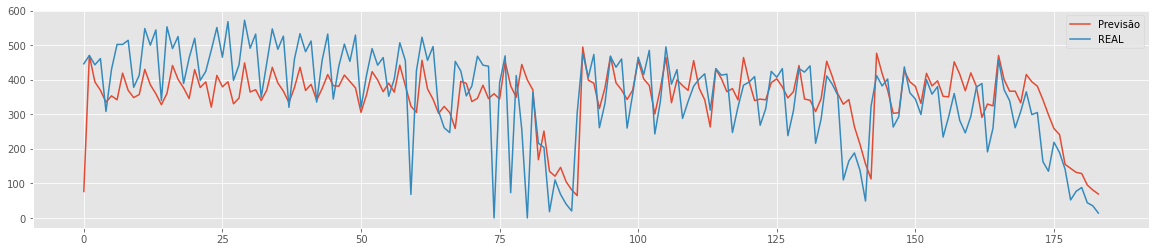

TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 64170.63 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.6606462451035008 Pi (p) :1.9184607118463233e-24


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE = 102.80909876605612
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6437.710876464844
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 7904.081573486328
ERRO ABSOLUTO MEDIANO = 61.39728546142578
ERRO ABSOLUTO PERCENTUAL MEDIO = 4124092635.50105%


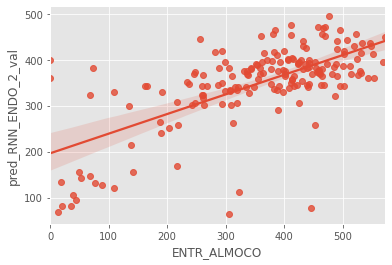

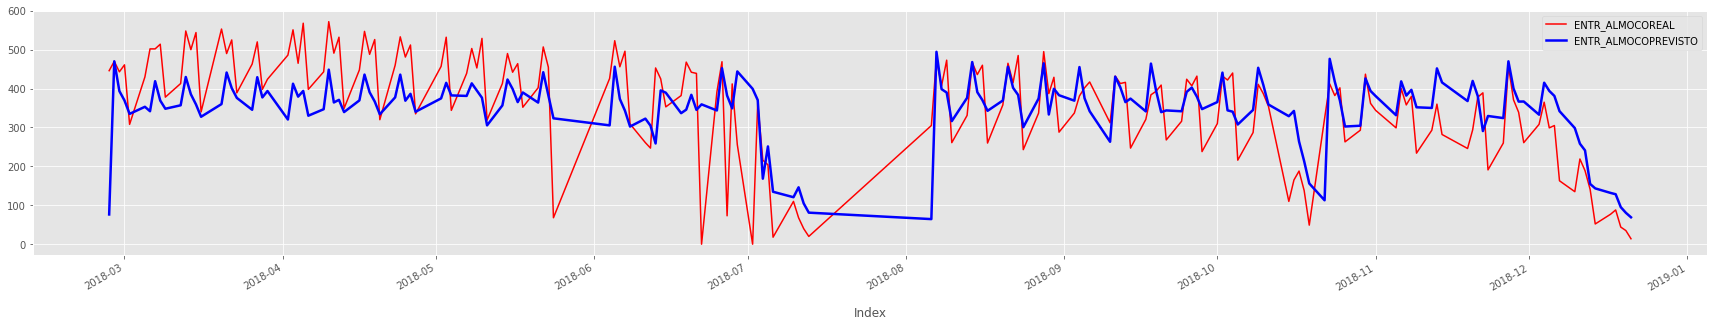

In [ ]:
#RNN_ENDO_2
model_name = 'RNN_ENDO_2'
model = RNN_ENDO_2
pred_y = model.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

###MLP_ENDO_1

RMSE:  89.32526704475531


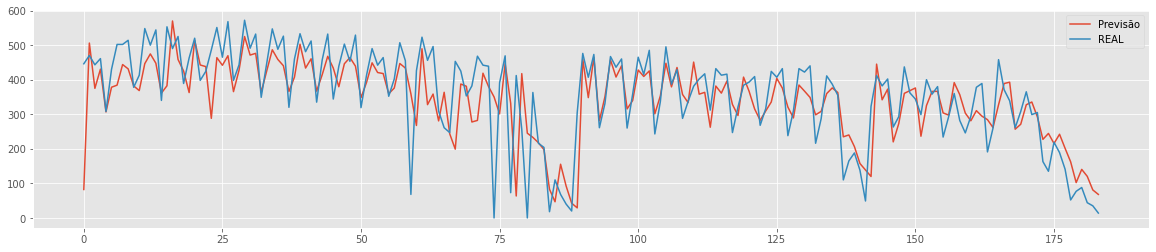

TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 62781.324 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.7649396511306203 Pi (p) :1.3054591862307924e-36


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RMSE = 89.32526704475531
TOTAL DE REFEIÇÕES SUB PROJETADAS = -4257.537273406982
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 7113.216419219971
ERRO ABSOLUTO MEDIANO = 47.23118591308594
ERRO ABSOLUTO PERCENTUAL MEDIO = 3234942340.243013%


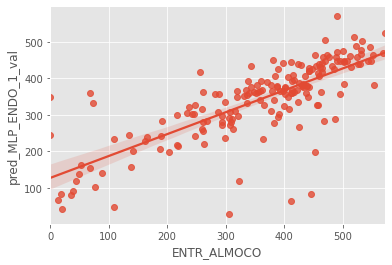

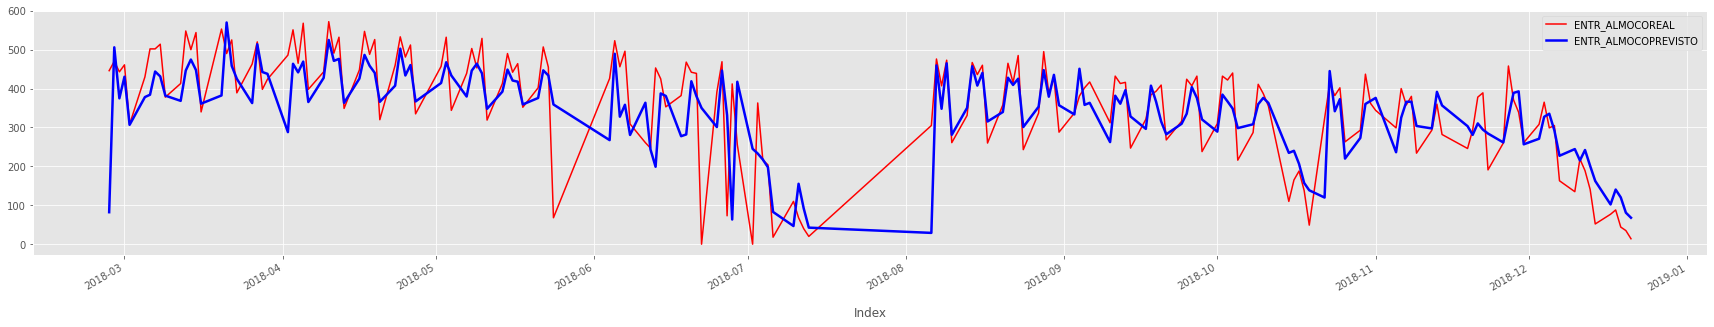

In [ ]:
#RNN_ENDO_2
model_name = 'MLP_ENDO_1'
model = MLP_ENDO_1
pred_y = model.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

In [ ]:
RNN_ENDO_1.save(prefix+'RNN_ENDO_1_validated.h5')
RNN_ENDO_2.save(prefix+'RNN_ENDO_2_validated.h5')
MLP_ENDO_1.save(prefix+'MLP_ENDO_1_validated.h5')

## **Modelos que usam dados endógenos e exógenos**

In [ ]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_dense_features = train_x_dense.shape[1]
num_output = 1
print('Numero de valores totais na entrada da rede:', num_lags * num_features + num_dense_features)

Numero de valores totais na entrada da rede: 25


#### **RNN_EXO_1 RNN e DENSO (multinput) - UMA CAMADA RNN E UMA DENSA**

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=False)(input_layer_recorrente)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru, layer_dense])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
RNN_EXO_1 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################
RNN_EXO_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(RNN_EXO_1, show_shapes=True)
RNN_EXO_1.save_weights(prefix + 'RNN_EXO_1' + "_wheigts_initial.h5")

#### **RNN_EXO_2 MODELO RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (SEM DROPOUT)**

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=True)(input_layer_recorrente)
layer_gru_2 = layers.GRU(16, )(layer_gru)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
RNN_EXO_2 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################
RNN_EXO_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(RNN_EXO_2, show_shapes=True)
RNN_EXO_2.save_weights(prefix + 'RNN_EXO_2' + "_wheigts_initial.h5")

#### **RNN_EXO_3 RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (COM DROPOUT)**


In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(16, return_sequences=True)(input_layer_recorrente)
layer_dropout = layers.Dropout(0.2)(layer_gru)
layer_gru_2 = layers.GRU(32,)(layer_dropout)
layer_dropout_2 = layers.Dropout(0.2)(layer_gru_2)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_dropout_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
RNN_EXO_3 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################
RNN_EXO_3.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(RNN_EXO_3, show_shapes=True)
RNN_EXO_3.save_weights(prefix + 'RNN_EXO_3' + "_wheigts_initial.h5")

#### **TREINOS MODELOS MULTINPUT**

#### **RNN_EXO_1**

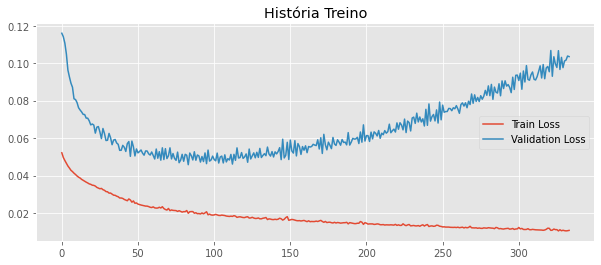

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = RNN_EXO_1.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **RNN_EXO_2**

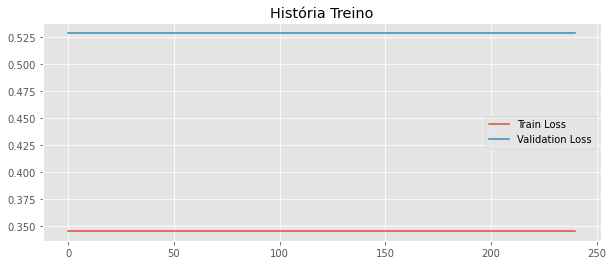

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = RNN_EXO_2.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **RNN_EXO_3**

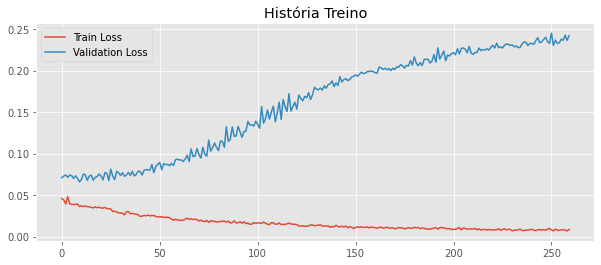

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = RNN_EXO_3.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **AVALIAÇÂO DO MODELO**

#### **RNN_EXO_1**

RMSE:  109.97634427462593
TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 62530.465 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.6052852633603059 Pi (p) :8.961737817855194e-20
RMSE = 109.97634427462593
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6378.557273864746
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 9485.092361450195
ERRO ABSOLUTO MEDIANO = 67.952392578125
ERRO ABSOLUTO PERCENTUAL MEDIO = 3590946402.38917%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


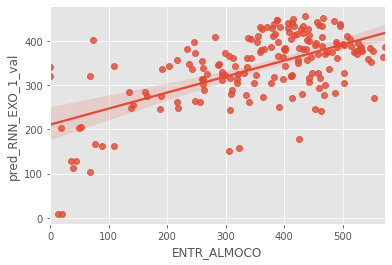

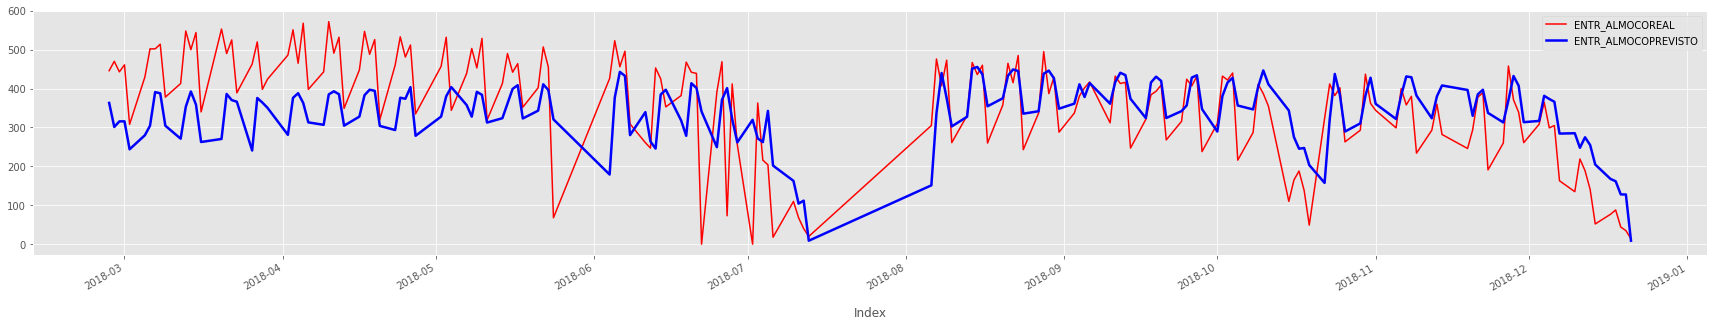

In [ ]:
#RNN_EXO_1
model_name = 'RNN_EXO_1'
model = RNN_EXO_1
x_validation = (scaled_val_x, val_x_dense)
pred_y = model.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = df_val['ENTR_ALMOCO']
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_EXO_2**

RMSE:  373.5611599422393
TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 1656.0 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): nan Pi (p) :nan
RMSE = 373.5611599422393
TOTAL DE REFEIÇÕES SUB PROJETADAS = -18.0
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 63999.0
ERRO ABSOLUTO MEDIANO = 380.0
ERRO ABSOLUTO PERCENTUAL MEDIO = 97826180.62563947%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


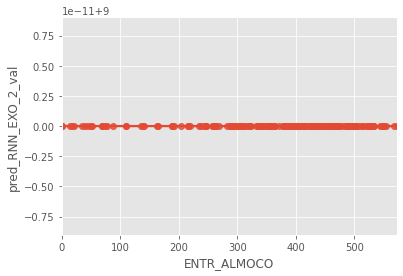

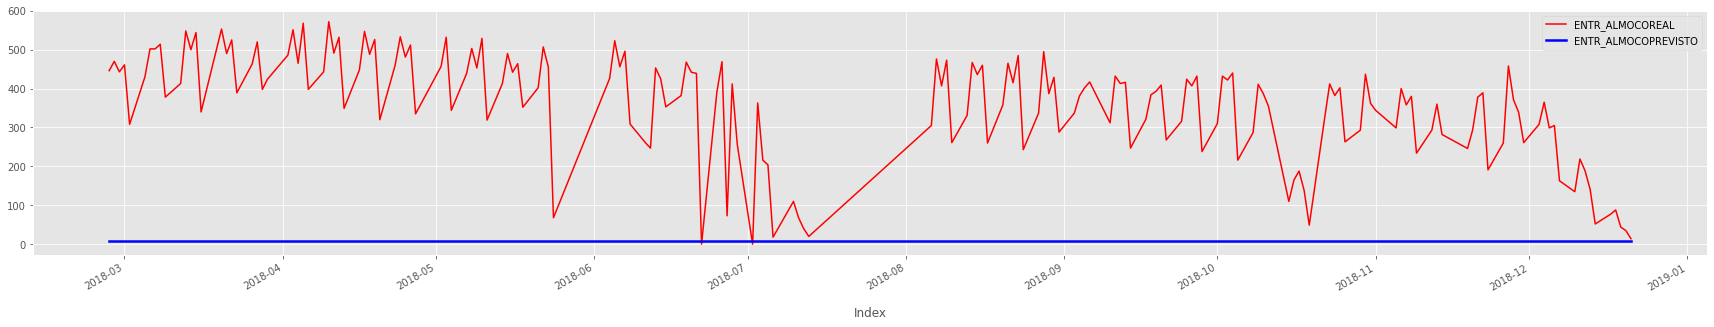

In [ ]:
#RNN_EXO_2
model_name = 'RNN_EXO_2'
model = RNN_EXO_2
x_validation = (scaled_val_x, val_x_dense)
pred_y = model.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = df_val['ENTR_ALMOCO']
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_EXO_3**

RMSE:  131.93314687496996
TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 59270.867 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.3675645280265282 Pi (p) :2.8557023726066666e-07
RMSE = 131.93314687496996
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6869.128311157227
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 13235.260711669922
ERRO ABSOLUTO MEDIANO = 101.04127502441406
ERRO ABSOLUTO PERCENTUAL MEDIO = 3493320353.99382%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


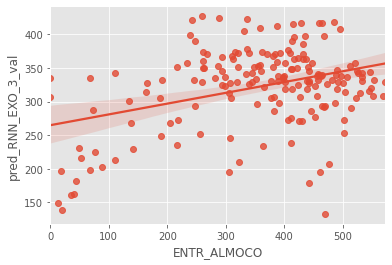

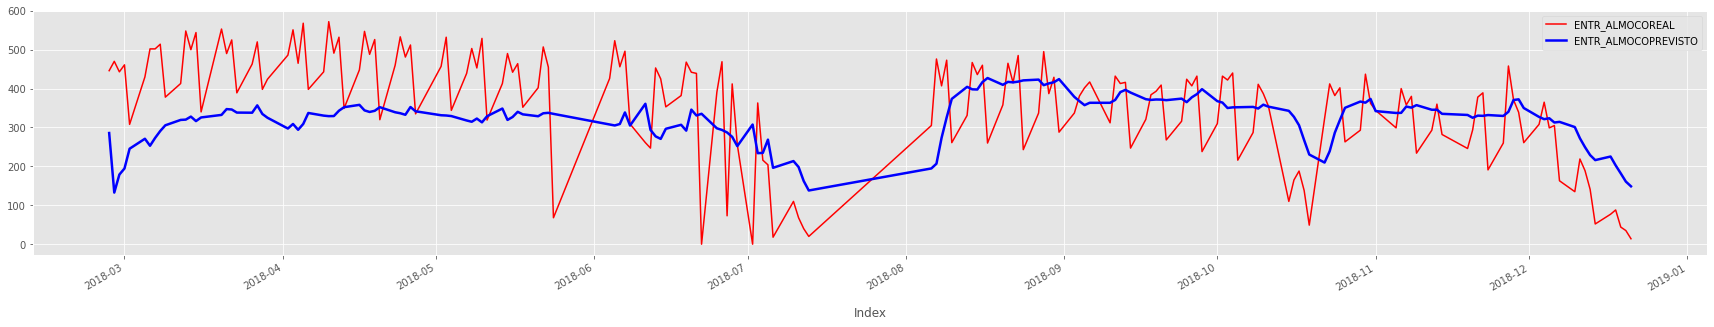

In [ ]:
#RNN_EXO_3
model_name = 'RNN_EXO_3'
model = RNN_EXO_3
x_validation = (scaled_val_x, val_x_dense)
pred_y = model.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = df_val['ENTR_ALMOCO']
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

# RESULTADOS DAS AVALIAÇÕES


*   TOTAL PROJETADO
*   TOTAL CONSUMIDO
*   TOTAL SUBPROJETADO
*   TOTAL SUPER PROJETADO
*   ERRO ABSOLUTO MEDIO
*   ERRO PERCENTUAL MEDIO



In [ ]:
df_models_metrics

CORRELACAO  ...            pi
RU_JANTAR_PRED         0.476713  ...  1.025481e-11
MLP1_predictions            NaN  ...           NaN
MLP2_predictions       0.731596  ...  4.201676e-32
pred_RNN_ENDO_1_val    0.753810  ...  5.014834e-35
pred_RNN_ENDO_2_val    0.660646  ...  1.918461e-24
pred_MLP_ENDO_1_val    0.764940  ...  1.305459e-36
pred_RNN_EXO_1_val     0.605285  ...  8.961738e-20
pred_RNN_EXO_2_val          NaN  ...           NaN
pred_RNN_EXO_3_val     0.367565  ...  2.855702e-07

[9 rows x 11 columns]

In [ ]:
RNN_EXO_1.save(prefix + 'RNN_EXO_1_validated.h5')
RNN_EXO_2.save(prefix + 'RNN_EXO_2_validated.h5')
RNN_EXO_3.save(prefix + 'RNN_EXO_3_validated.h5')

# REDEFINIÇÃO / TREINO E REAVALIAÇÃO DO rnn_unique_1

In [ ]:
#RNN_ENDO_1_NEW
###################### modelo RNN com uma única camada 
RNN_ENDO_1_NEW = keras.Sequential()
num_units = 25 # ajustavel
RNN_ENDO_1_NEW.add(layers.GRU(num_units, input_shape=(num_lags, num_features),))
RNN_ENDO_1_NEW.add(layers.Dense(num_output, activation='linear'))
RNN_ENDO_1_NEW.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(RNN_ENDO_1_NEW, show_shapes=True)
RNN_ENDO_1_NEW.save_weights(prefix + 'RNN_ENDO_1_NEW' + "_wheigts_initial.h5")
######################

(148, 5, 3) (148,)


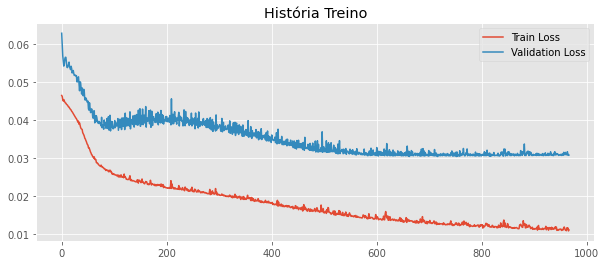

In [ ]:
#RNN_ENDO_1_NEW
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = RNN_ENDO_1_NEW.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 65219.613 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.7538102329191316 Pi (p) :5.014834155014456e-35
RMSE = 89.73281442880939
TOTAL DE REFEIÇÕES SUB PROJETADAS = -5666.187889099121
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 6083.576965332031
ERRO ABSOLUTO MEDIANO = 48.55305480957031
ERRO ABSOLUTO PERCENTUAL MEDIO = 4145884336.345922%


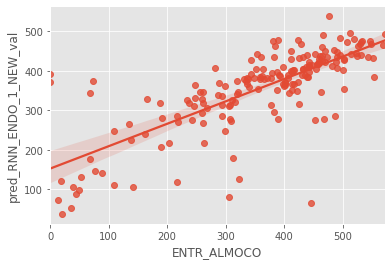

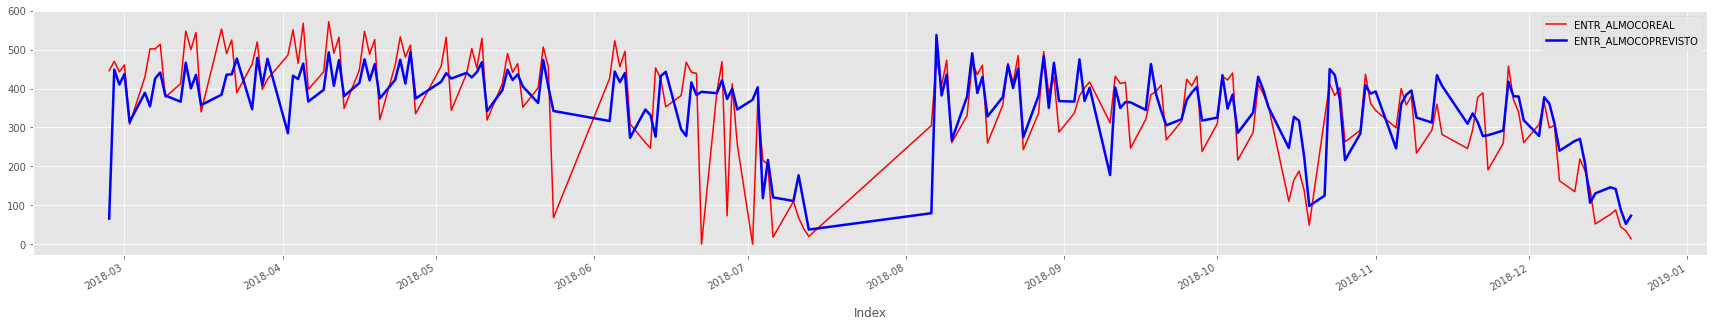

In [ ]:
#RNN_ENDO_1_NEW
model_name = 'RNN_ENDO_1_NEW'
model = RNN_ENDO_1
pred_y = model.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)

reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

# REDEFINIÇÃO / TREINO E REAVALIAÇÃO DO multiinput_model_1

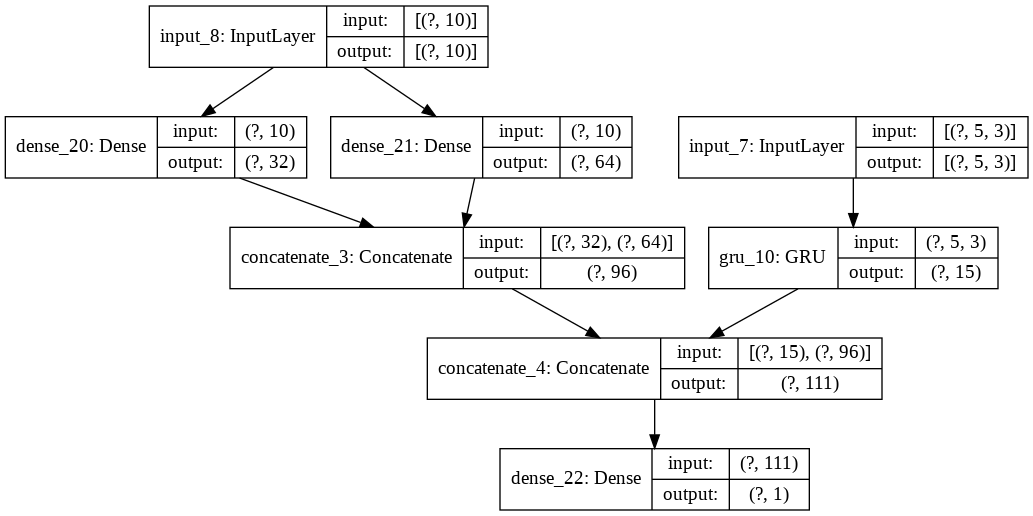

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(15, return_sequences=False)(input_layer_recorrente)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense1 = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense2 = layers.Dense(64, activation='relu')(input_layer_dense)
layer_dense = layers.concatenate([layer_dense1, layer_dense2])
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru , layer_dense])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
RNN_EXO_1_NEW = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################

RNN_EXO_1_NEW.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(RNN_EXO_1_NEW, show_shapes=True)

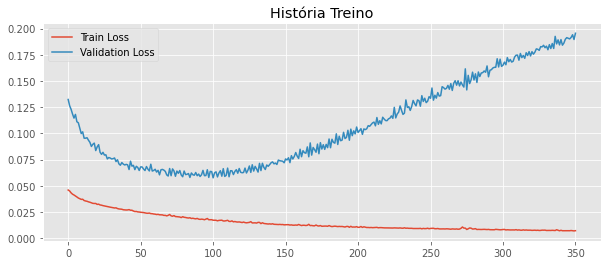

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = RNN_EXO_1_NEW.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


TOTAL DE REFEIÇÕES CONSUMIDAS = 65637 : 184 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 60340.348 : 184 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.48916770613433336 Pi (p) :1.8443370849764134e-12
RMSE = 123.26867235935819
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6135.284713745117
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 11431.938186645508
ERRO ABSOLUTO MEDIANO = 75.63948059082031
ERRO ABSOLUTO PERCENTUAL MEDIO = 4177096364.659741%


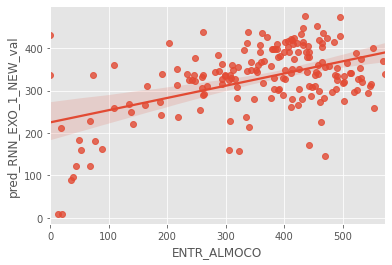

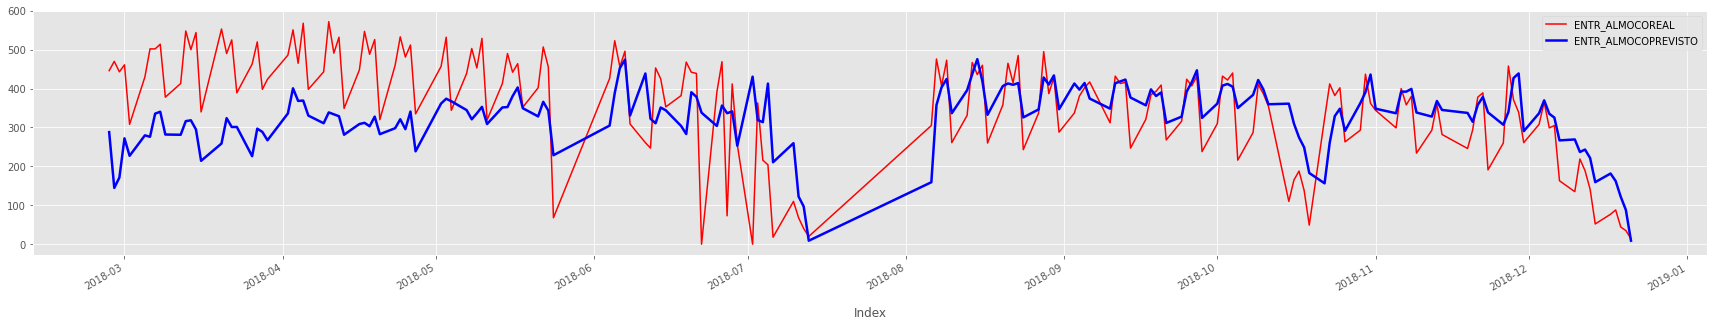

In [ ]:
model_name = 'RNN_EXO_1_NEW'
x_validation = (scaled_val_x, val_x_dense)
pred_y = RNN_EXO_1_NEW.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = df_val['ENTR_ALMOCO']
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
reg = 'pred_' + model_name + '_val'
df_val[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_val,'ENTR_ALMOCO', reg , df_models_metrics)

In [ ]:
df_models_metrics

CORRELACAO  ...            pi
RU_JANTAR_PRED             0.476713  ...  1.025481e-11
MLP1_predictions                NaN  ...           NaN
MLP2_predictions           0.731596  ...  4.201676e-32
pred_RNN_ENDO_1_val        0.753810  ...  5.014834e-35
pred_RNN_ENDO_2_val        0.660646  ...  1.918461e-24
pred_MLP_ENDO_1_val        0.764940  ...  1.305459e-36
pred_RNN_EXO_1_val         0.605285  ...  8.961738e-20
pred_RNN_EXO_2_val              NaN  ...           NaN
pred_RNN_EXO_3_val         0.367565  ...  2.855702e-07
pred_RNN_ENDO_1_NEW_val    0.753810  ...  5.014834e-35
pred_RNN_EXO_1_NEW_val     0.489168  ...  1.844337e-12

[11 rows x 11 columns]

In [ ]:
RNN_ENDO_1_NEW.save(prefix + 'RNN_ENDO_1_NEW_validated.h5')

# **TESTE - FINAL**

### *MODELOS ENDÓGENOS*
model_rnn_unique_1
model_rnn_unique_2
model_mlp_unique_2

#### MODELO REDEFINIDO

RMSE:  103.49465460223492
TOTAL DE REFEIÇÕES CONSUMIDAS = 58653 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 61975.14 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.6483385209742342 Pi (p) :4.4063208337015015e-23
RMSE = 103.49465460223492
TOTAL DE REFEIÇÕES SUB PROJETADAS = -8183.8604526519775
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 4861.716590881348
ERRO ABSOLUTO MEDIANO = 54.174461364746094
ERRO ABSOLUTO PERCENTUAL MEDIO = 100.84183860101624%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


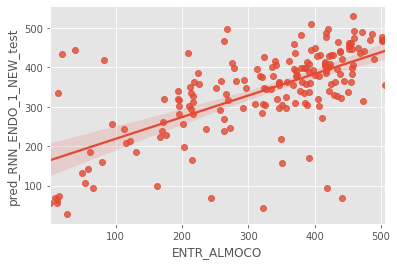

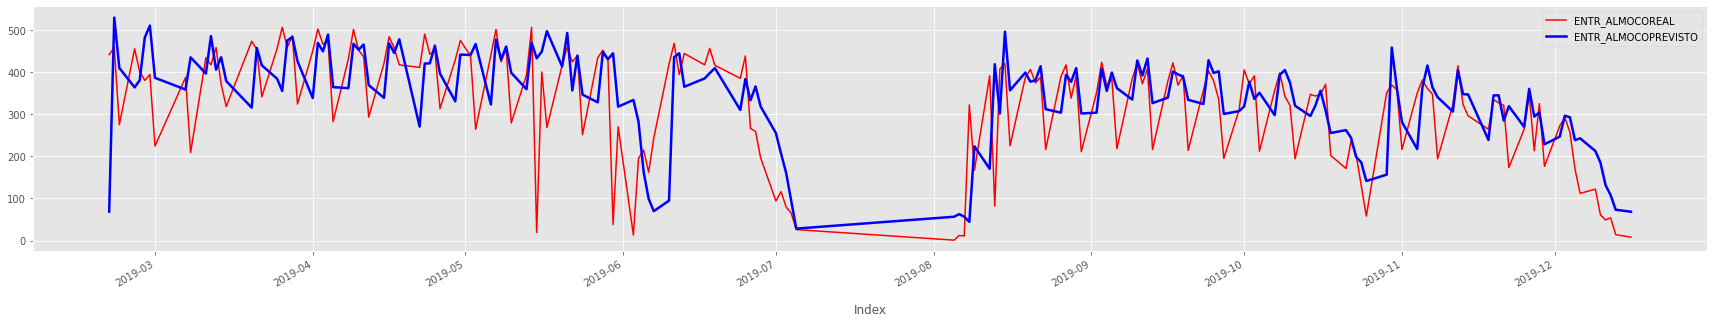

In [ ]:
#RNN_ENDO_1
model_name = 'RNN_ENDO_1_NEW'
model = RNN_ENDO_1_NEW
x_test = scaled_test_x
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)

# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))

reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_ENDO_1**

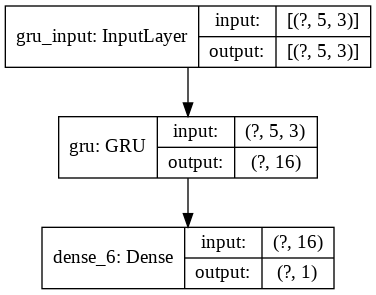

In [ ]:
keras.utils.plot_model(RNN_ENDO_1, show_shapes=True)

RMSE:  99.42701516854169
TOTAL DE REFEIÇÕES CONSUMIDAS = 58653 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 61595.992 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.6716169382451868 Pi (p) :3.1644443736452066e-25
RMSE = 99.42701516854169
TOTAL DE REFEIÇÕES SUB PROJETADAS = -7632.491046905518
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 4689.499412536621
ERRO ABSOLUTO MEDIANO = 45.211883544921875
ERRO ABSOLUTO PERCENTUAL MEDIO = 106.53800241263487%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


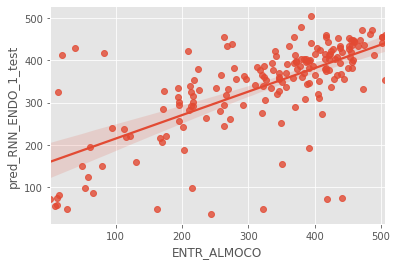

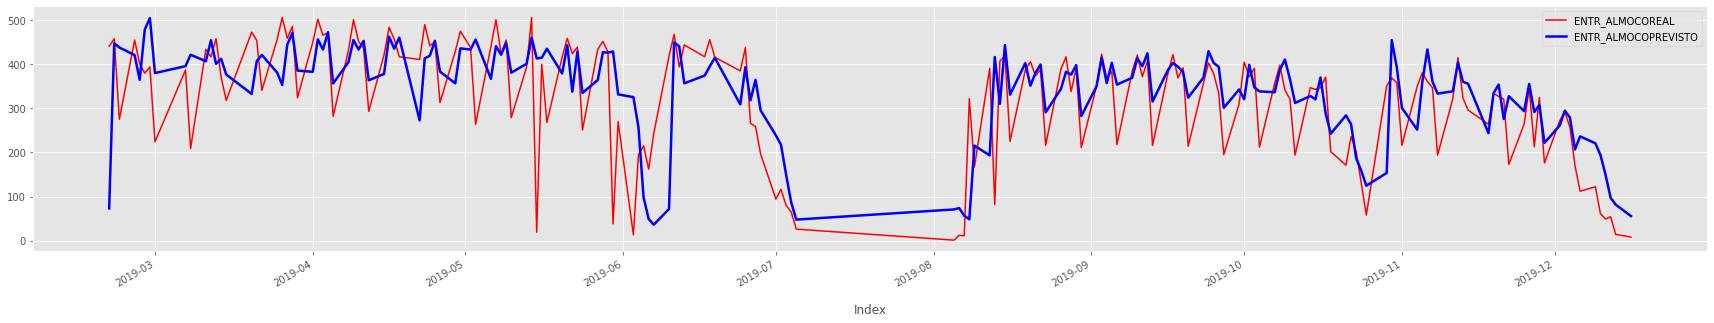

In [ ]:
#RNN_ENDO_1
model_name = 'RNN_ENDO_1'
model = RNN_ENDO_1
x_test = scaled_test_x
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)

# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))

reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


TOTAL DE REFEIÇÕES CONSUMIDAS = 58653 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 61595.992 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.6716169382451868 Pi (p) :3.1644443736452066e-25
RMSE = 99.42701516854169
TOTAL DE REFEIÇÕES SUB PROJETADAS = -7632.491046905518
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 4689.499412536621
ERRO ABSOLUTO MEDIANO = 45.211883544921875
ERRO ABSOLUTO PERCENTUAL MEDIO = 106.53800241263487%


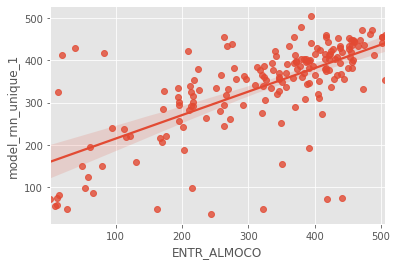

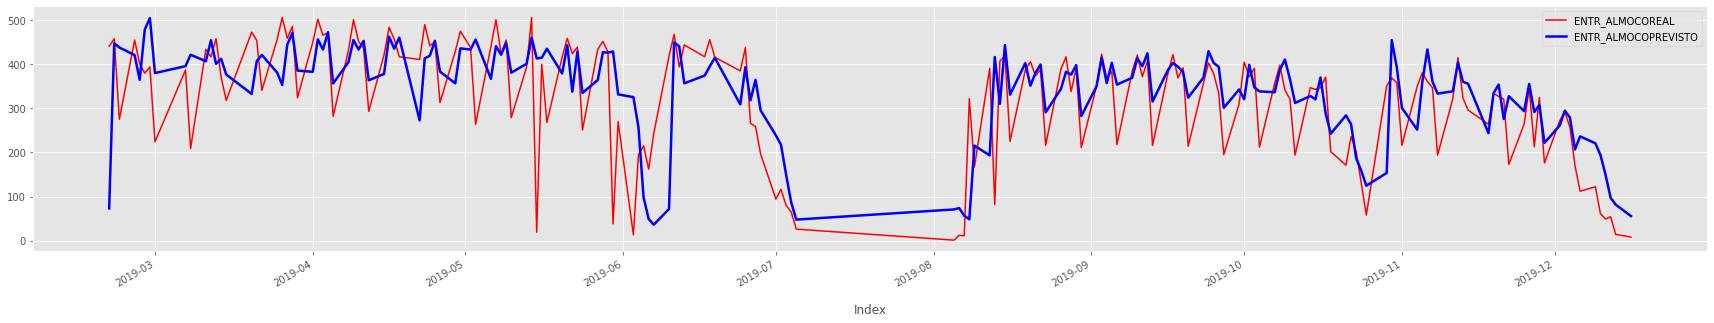

In [ ]:
df_test['model_rnn_unique_1'] = pred_y
df_models_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', 'model_rnn_unique_1',df_models_metrics)

#### **RNN_ENDO_2**

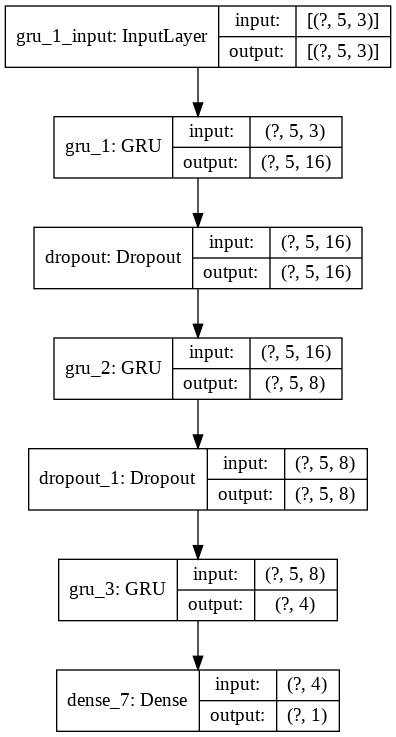

In [ ]:
keras.utils.plot_model(RNN_ENDO_2, show_shapes=True)

RMSE:  106.46238262525253
TOTAL DE REFEIÇÕES CONSUMIDAS = 58653 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 63051.957 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.6200924293587189 Pi (p) :1.0164846645515267e-20
RMSE = 106.46238262525253
TOTAL DE REFEIÇÕES SUB PROJETADAS = -9433.780403137207
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 5034.823482513428
ERRO ABSOLUTO MEDIANO = 59.31929016113281
ERRO ABSOLUTO PERCENTUAL MEDIO = 107.77731927531866%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


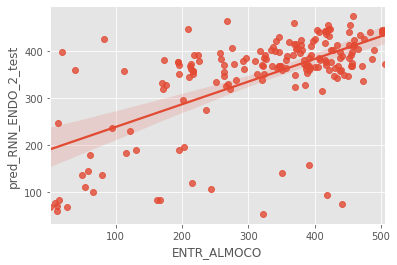

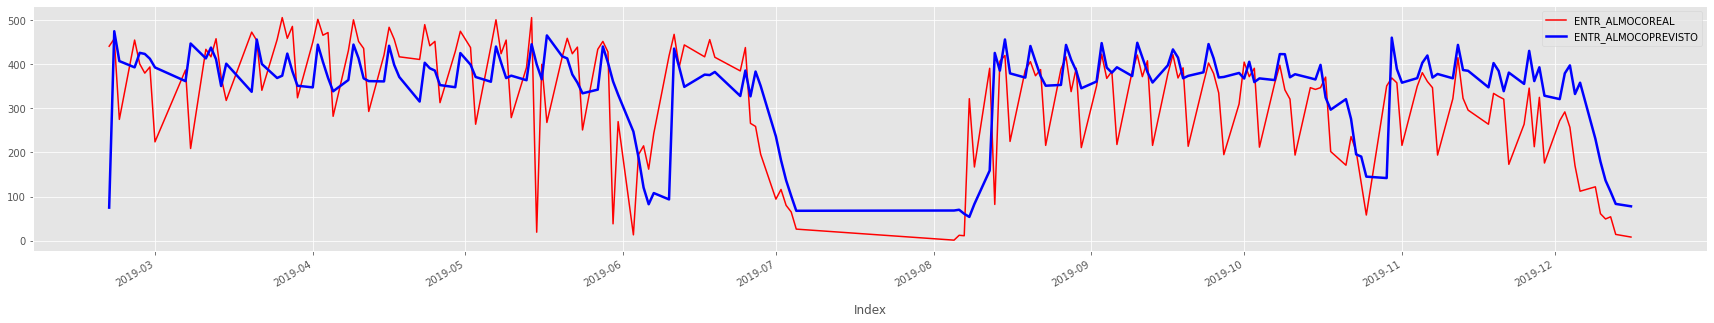

In [ ]:
#RNN_ENDO_2
model_name = 'RNN_ENDO_2'
model = RNN_ENDO_2
x_test = scaled_test_x
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)

# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))

reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

#### **MLP_ENDO_1**

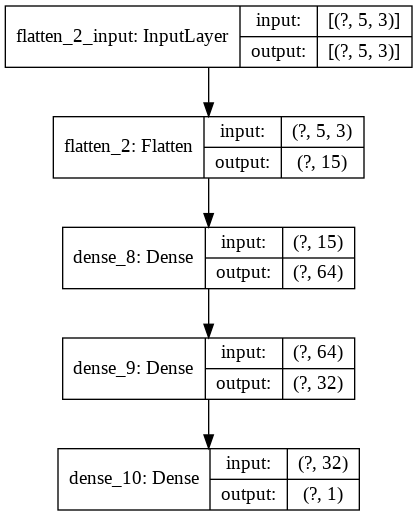

In [ ]:
keras.utils.plot_model(MLP_ENDO_1, show_shapes=True)

RMSE:  101.59851042304052
TOTAL DE REFEIÇÕES CONSUMIDAS = 58653 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 58252.28 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.6427849335965454 Pi (p) :1.3435438140371988e-22
RMSE = 101.59851042304052
TOTAL DE REFEIÇÕES SUB PROJETADAS = -6422.831230163574
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 6823.552013397217
ERRO ABSOLUTO MEDIANO = 55.85721969604492
ERRO ABSOLUTO PERCENTUAL MEDIO = 117.43297606468121%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


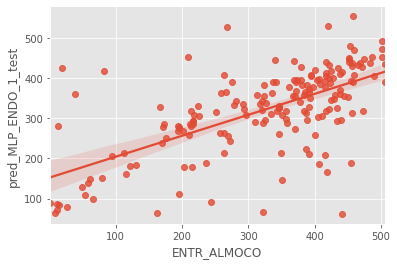

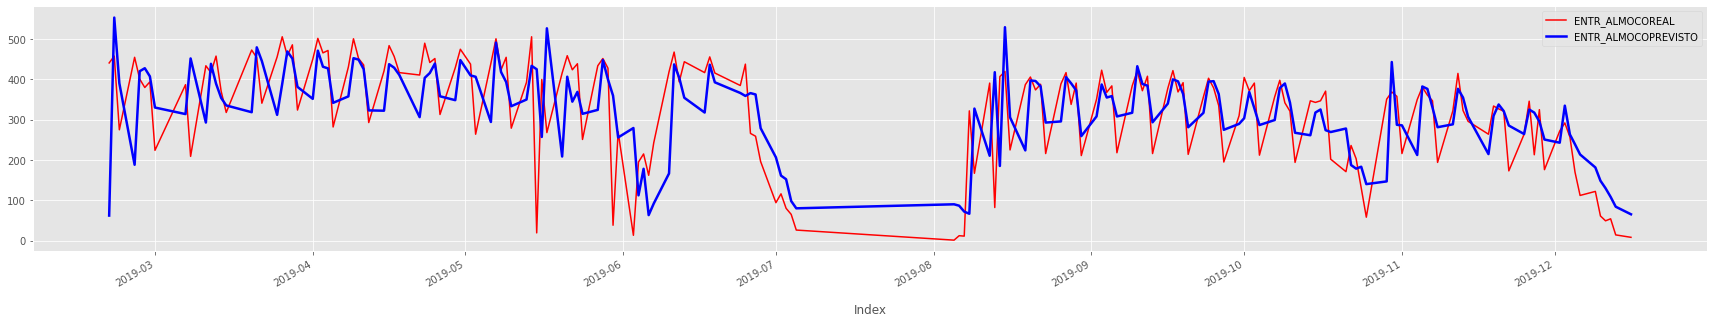

In [ ]:
#MLP_ENDO_1
model_name = 'MLP_ENDO_1'
model = MLP_ENDO_1
x_test = scaled_test_x
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)

# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))

reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

### *MODELOS MISTOS ENDÓGENOS E EXÓGENOS*
multiinput_model_1
multiinput_model_2
multiinput_model_3

#### **RNN_EXO_1**

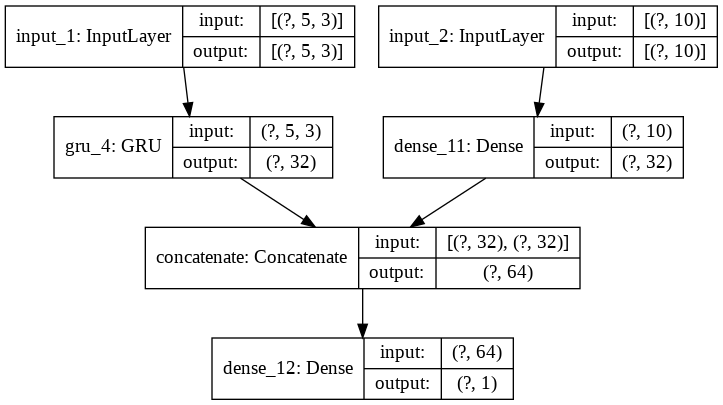

In [ ]:
keras.utils.plot_model(RNN_EXO_1, show_shapes=True)

RMSE:  108.39471405056577
TOTAL DE REFEIÇÕES CONSUMIDAS = 58653 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 59631.805 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.5666807863343017 Pi (p) :7.523438492268606e-17
RMSE = 108.39471405056577
TOTAL DE REFEIÇÕES SUB PROJETADAS = -8201.954574584961
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 7223.150077819824
ERRO ABSOLUTO MEDIANO = 70.16781616210938
ERRO ABSOLUTO PERCENTUAL MEDIO = 201.0701177733505%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


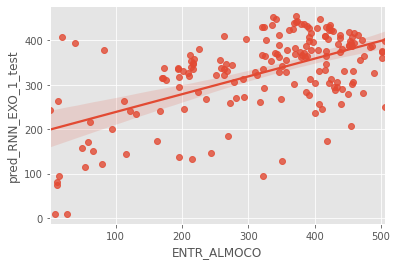

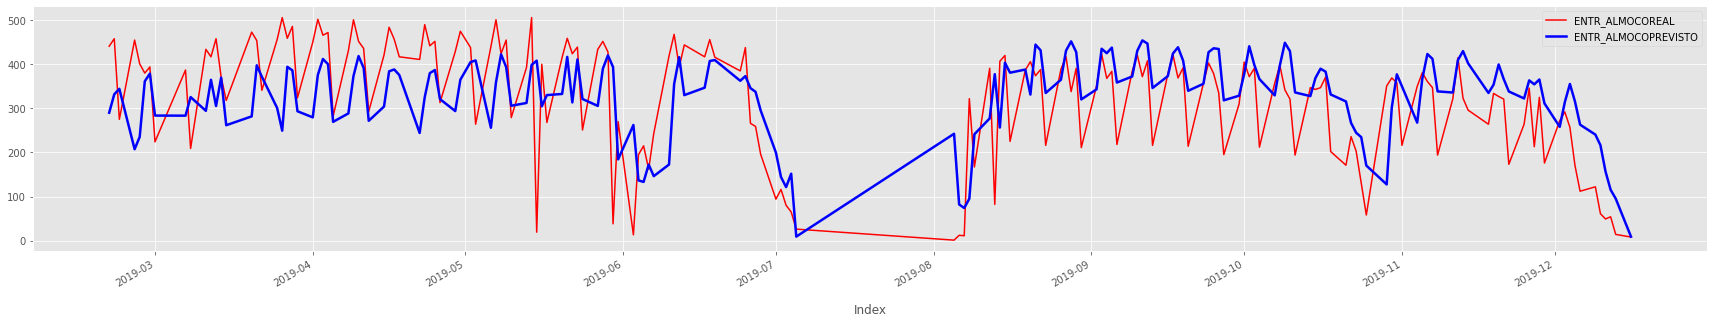

In [ ]:
#RNN_EXO_1
model_name = 'RNN_EXO_1'
model = RNN_EXO_1
x_test = (scaled_test_x, test_x_dense)
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_EXO_2**

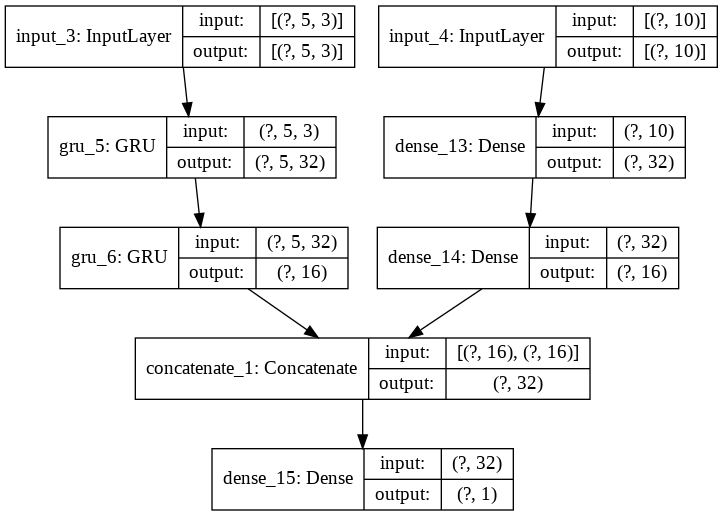

In [ ]:
keras.utils.plot_model(RNN_EXO_2, show_shapes=True)

RMSE:  338.99452976234176
TOTAL DE REFEIÇÕES CONSUMIDAS = 58653 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 1638.0 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): nan Pi (p) :nan
RMSE = 338.99452976234176
TOTAL DE REFEIÇÕES SUB PROJETADAS = -9.0
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 57024.0
ERRO ABSOLUTO MEDIANO = 350.5
ERRO ABSOLUTO PERCENTUAL MEDIO = 97.98887198655513%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


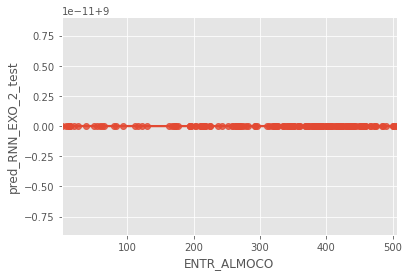

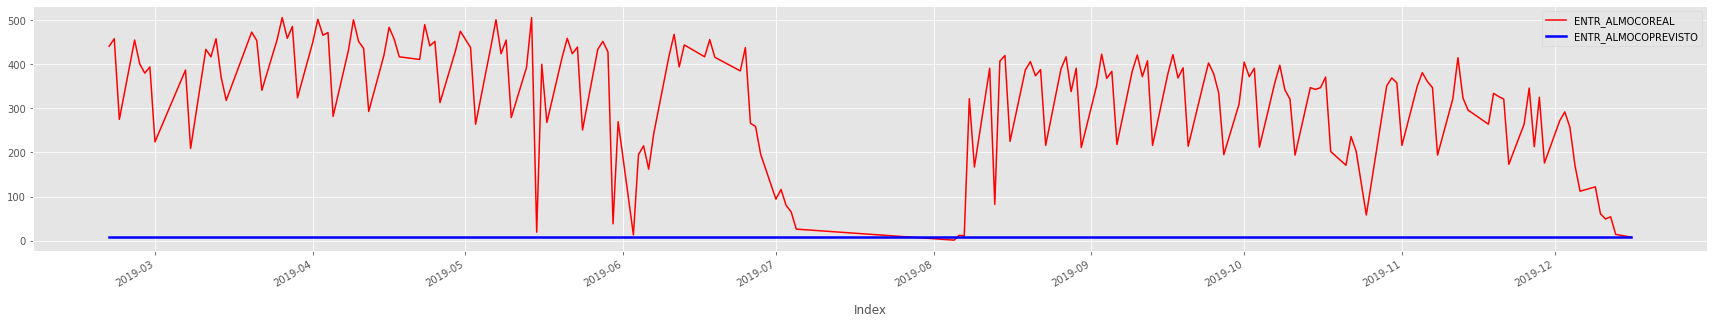

In [ ]:
#RNN_EXO_2
model_name = 'RNN_EXO_2'
model = RNN_EXO_2
x_test = (scaled_test_x, test_x_dense)
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

#### **RNN_EXO_3**

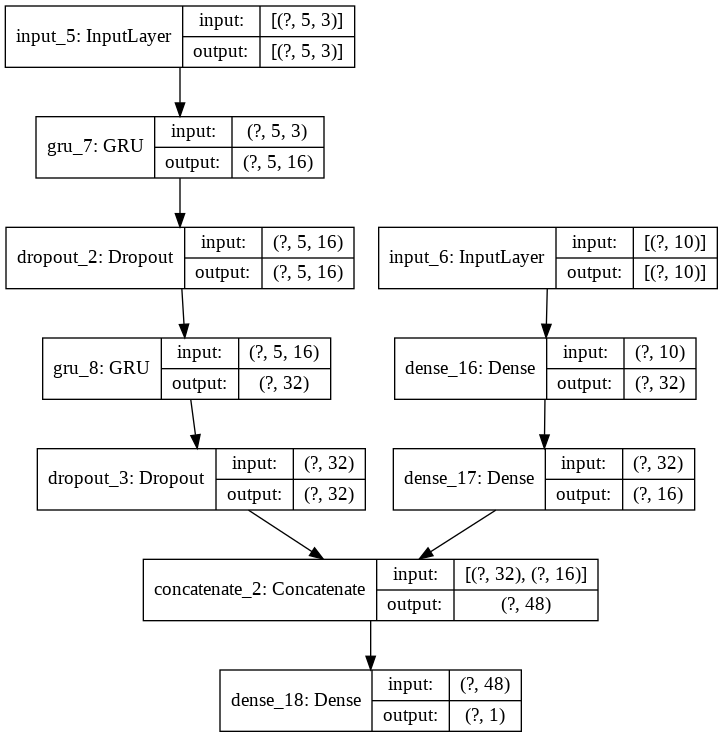

In [ ]:
keras.utils.plot_model(RNN_EXO_3, show_shapes=True)

RMSE:  120.10062493459316
TOTAL DE REFEIÇÕES CONSUMIDAS = 58653 : 182 linhas
TOTAL DE REFEIÇÕES PROJETADAS = 55600.95 : 182 linhas
ERRO DE PREVISÃO = 0 0.0 % do total consumido
CORRELAÇÃO (r): 0.4056867029890125 Pi (p) :1.3350418338913426e-08
RMSE = 120.10062493459316
TOTAL DE REFEIÇÕES SUB PROJETADAS = -7372.359306335449
TOTAL DE REFEIÇÕES SUPER PROJETADAS = 10424.411613464355
ERRO ABSOLUTO MEDIANO = 99.67792510986328
ERRO ABSOLUTO PERCENTUAL MEDIO = 213.92302870368033%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


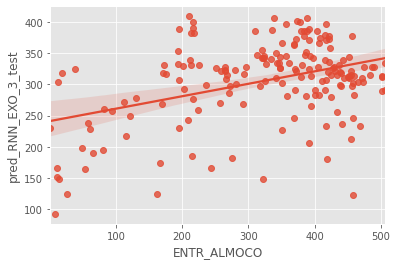

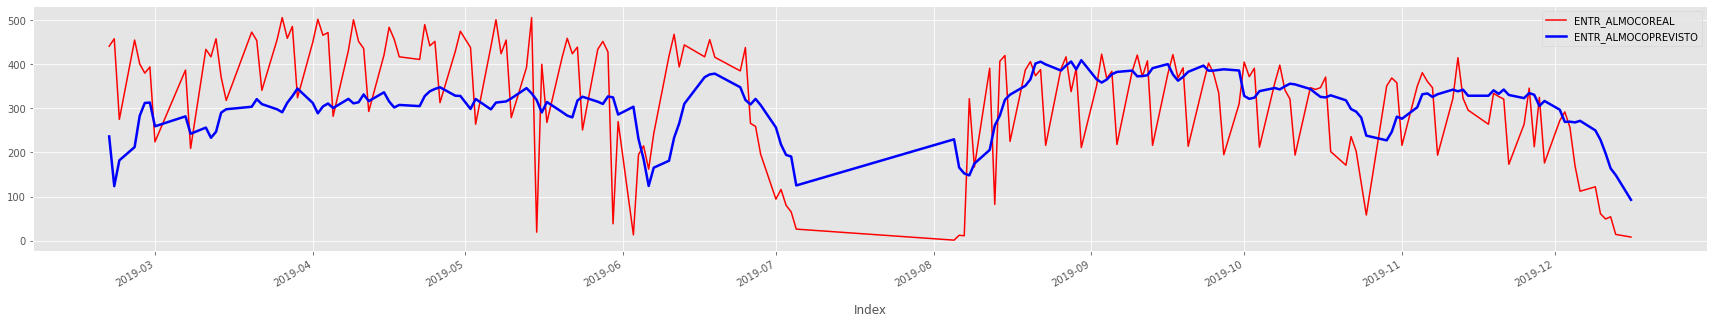

In [ ]:
#RNN_EXO_3
model_name = 'RNN_EXO_3'
model = RNN_EXO_3
x_test = (scaled_test_x, test_x_dense)
pred_y = model.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# calcula erros
mse = mean_squared_error(df_test['ENTR_ALMOCO'], pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
reg = 'pred_' + model_name + '_test'
df_test[reg] = pred_y
df_models_metrics = avaliacao_predicoes(df_test,'ENTR_ALMOCO', reg , df_models_metrics)

In [ ]:
df_models_metrics

CORRELACAO  ...            pi
RU_JANTAR_PRED              0.476713  ...  1.025481e-11
MLP1_predictions                 NaN  ...           NaN
MLP2_predictions            0.731596  ...  4.201676e-32
pred_RNN_ENDO_1_val         0.753810  ...  5.014834e-35
pred_RNN_ENDO_2_val         0.660646  ...  1.918461e-24
pred_MLP_ENDO_1_val         0.764940  ...  1.305459e-36
pred_RNN_EXO_1_val          0.605285  ...  8.961738e-20
pred_RNN_EXO_2_val               NaN  ...           NaN
pred_RNN_EXO_3_val          0.367565  ...  2.855702e-07
pred_RNN_ENDO_1_NEW_val     0.753810  ...  5.014834e-35
pred_RNN_EXO_1_NEW_val      0.489168  ...  1.844337e-12
pred_RNN_ENDO_1_NEW_test    0.648339  ...  4.406321e-23
pred_RNN_ENDO_1_test        0.671617  ...  3.164444e-25
model_rnn_unique_1          0.671617  ...  3.164444e-25
pred_RNN_ENDO_2_test        0.620092  ...  1.016485e-20
pred_MLP_ENDO_1_test        0.642785  ...  1.343544e-22
pred_RNN_EXO_1_test         0.566681  ...  7.523438e-17
pred_RNN_EXO_2_test              NaN  ...           NaN
pred_RNN_EXO_3_test         0.405687  ...  1.335042e-08

[19 rows x 11 columns]

# EXPORTANDO SCALERS, RESULTADOS E DATAFRAMES

In [ ]:
# EXPORTAÇÃO DOS SCALERS, DATAFRAMES NORMALIZADOS E DATAFRAMES ESCALADOS
# Lib para exportar scalers, JOBLIB
# para carregar -> #scaler_numpont = load('scaler_numpont.joblib')

# Exportando scaler treinando das features numericas não temporais
path = prefix+'scaler_numpont.joblib'
dump(scaler_numpont, path)

path = prefix+'rnn_scalers_arr.joblib'
# Exportando mapa <String,Scaler> de scalers treinados das features recorrentes
dump(scalers, path)

# EXPORTANDO DATAFRAMES TO PICKLE
# PARAMETROS DO PRE-PROCESSAMENTO
preprocessamento_parameters = pd.DataFrame()
preprocessamento_parameters['periodo_de_treino'] = ["2017",""]
preprocessamento_parameters['periodo_de_validacao'] = ["2018",""] # ,"" -> adicionando linha dummy para o dataframe não ficar esparso.
preprocessamento_parameters['periodo_de_teste'] = ["2019",""]
preprocessamento_parameters['features_categoricas'] = [features_categoricas,""]
preprocessamento_parameters['features_numericas_pontuais'] = [features_numericas_pontuais,""]
preprocessamento_parameters['features_temporais'] = [features_temporais,""]
preprocessamento_parameters['feature_to_predict'] = [feature_to_predict,""]

preprocessamento_parameters.to_pickle(prefix+"preprocessamento_parameters.pkl")

df_train.to_pickle(prefix+"df_train.pkl")
df_val.to_pickle(prefix+"df_val.pkl")
df_test.to_pickle(prefix+"df_test.pkl")

df_models_metrics.to_pickle(prefix+'df_models_metrics.pkl')

#%%

# Exportando NUMPY ARRAYS usando biblioteca h5py (DATAFRAMES USAM PICKLE, METODO PROPRIO DO PANDAS)
path = prefix+'np_data.h5'
hf = h5py.File(path, 'w')

#%%

# Dados Recorrentes, escalados
hf.create_dataset('scaled_train_x', data = scaled_train_x)

hf.create_dataset('scaled_val_x', data = scaled_val_x)

hf.create_dataset('scaled_test_x', data = scaled_test_x)


# Dados Categóricos (dias da semana e semestre já escalados no df original)
# concatenados com Dados Pontuais (climáticos) escalados
hf.create_dataset('train_x_dense', data = train_x_dense)

hf.create_dataset('val_x_dense', data = val_x_dense)

hf.create_dataset('test_x_dense', data = test_x_dense)

# Valores de supervisão (saída) de cada dataframe, escalados
hf.create_dataset('scaled_train_y', data = scaled_train_y)

hf.create_dataset('scaled_val_y', data = scaled_val_y)

hf.create_dataset('scaled_test_y', data = scaled_test_y)

#%%

# GRAVANDO E LIBERANDO O ARQUIVO
hf.close()

In [ ]:
df_test

SEMESTRE_1  SEMESTRE_2  ...  pred_RNN_EXO_2_test  pred_RNN_EXO_3_test
DATA                                ...                                          
2019-02-20           1           0  ...                  9.0           236.302505
2019-02-21           1           0  ...                  9.0           123.536598
2019-02-22           1           0  ...                  9.0           182.052490
2019-02-25           1           0  ...                  9.0           212.131958
2019-02-26           1           0  ...                  9.0           283.106873
...                ...         ...  ...                  ...                  ...
2019-12-10           0           1  ...                  9.0           228.803314
2019-12-11           0           1  ...                  9.0           198.321136
2019-12-12           0           1  ...                  9.0           163.796082
2019-12-13           0           1  ...                  9.0           148.763229
2019-12-16           0           1  ...                  9.0            92.475624

[182 rows x 43 columns]

In [ ]:
df_test.to_csv(r'case2_df_test.csv')
df_test.to_excel("case2_df_test.xlsx")

df_val.to_csv(r'case2_df_val.csv')
df_val.to_excel("case2_df_val.xlsx")

df_models_metrics.to_csv(r'case2_df_models_metrics.csv')
df_models_metrics.to_excel("case2_df_models_metrics.xlsx")

preprocessamento_parameters.to_csv(r'case2_preprocessamento_parameters.csv')
preprocessamento_parameters.to_excel("case2_preprocessamento_parameters.xlsx")